# General Instructions to students:

1. There are 5 types of cells in this notebook. The cell type will be indicated within the cell.
    1. Markdown cells with problem written in it. (DO NOT TOUCH THESE CELLS) (**Cell type: TextRead**)
    2. Python cells with setup code for further evaluations. (DO NOT TOUCH THESE CELLS) (**Cell type: CodeRead**)
    3. Python code cells with some template code or empty cell. (FILL CODE IN THESE CELLS BASED ON INSTRUCTIONS IN CURRENT AND PREVIOUS CELLS) (**Cell type: CodeWrite**)
    4. Markdown cells where a written reasoning or conclusion is expected. (WRITE SENTENCES IN THESE CELLS) (**Cell type: TextWrite**)
    5. Temporary code cells for convenience and TAs. (YOU MAY DO WHAT YOU WILL WITH THESE CELLS, TAs WILL REPLACE WHATEVER YOU WRITE HERE WITH OFFICIAL EVALUATION CODE) (**Cell type: Convenience**)
    
2. You are not allowed to insert new cells in the submitted notebook.

3. You are not allowed to import any extra packages.

4. The code is to be written in Python 3.6 syntax. Latest versions of other packages maybe assumed.

5. In CodeWrite Cells, the only outputs to be given are plots asked in the question. Nothing else to be output/print. 

6. If TextWrite cells ask you to give accuracy/error/other numbers you can print them on the code cells, but remove the print statements before submitting.

7. The convenience code can be used to check the expected syntax of the functions. At a minimum, your entire notebook must run with "run all" with the convenience cells as it is. Any runtime failures on the submitted notebook as it is will get zero marks.

8. All code must be written by yourself. Copying from other students/material on the web is strictly prohibited. Any violations will result in zero marks.

9. All datasets will be given as .npz files, and will contain data in 4 numpy arrays :"X_train, Y_train, X_test, Y_test". In that order. The meaning of the 4 arrays can be easily inferred from their names.

10. All plots must be labelled properly, all tables must have rows and columns named properly.

11. Before subbmission ensure that you submit with the outputs (do not clear the outputs), so that when evaluating we can run selectively.

12. Before submission ensure that the path for the folder containing the data is "../../Data/" 


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
import matplotlib as mpl
import pandas as pd

# 1. Logistic Regression 

Write code for doing logistic regression below. Also write code for choosing best hyperparameters for each kernel type (use a part of training set as validation set). 

The range of hyperparameters is typically chosen on a log scale e.g. 1e-4, 1e-3, 1e-2... 1e3.

Write code for running in the cell after (You may be asked to demonstrate your code during the viva using this cell.)

In text cell after that report the following numbers you get by running appropriate code:

For each classification data set report the best kernel and regularisation parameters for linear, RBF and Poly kernels. (Linear has no kernel parameter.) Report the training and test zero-one error for those hyperparameters. 

For each given hyperparameter setting (kernel and regularisation) you will have to do some exploring to find the right learning rate to use in gradient descent. The optimisation learning rate is not a model hyperparameter and hence can be chosen based on just the training set. i.e. choose the learning rate for which the training loss decreases the most.

For the synthetic classification datasets (dataset_A and dataset_B) in 2-dimensions, also illustrate the learned classifier for each kernel setting. Do this in the last codeWrite cell for this question.


In [3]:
# CodeWrite 
#Write logistic regression code from scratch. Use gradient descent.
# Only write functions here
"""
from google.colab import drive
drive.mount('/content/gdrive')
"""

def normalize_data(X_train, X_hold_out, X_test) :
    X_train_mean = np.average(X_train, axis = 0)
    X_train_sd = np.std(X_train, axis = 0)
    divide_legal = 1
    if X_train_sd[X_train_sd == 0].shape[0] != 0 :
        divide_legal = 0
    if divide_legal == 1 :
        X_train = (X_train - X_train_mean)/(X_train_sd)
        X_test = (X_test - X_train_mean)/(X_train_sd)
        X_hold_out = (X_hold_out - X_train_mean)/(X_train_sd)
    else : 
        X_train = (X_train - X_train_mean)
        X_test = (X_test - X_train_mean)
        X_hold_out = (X_hold_out - X_train_mean)
    return (X_train, X_test, X_hold_out)

def train_holdout_split(X, Y, fraction = 0.8, randomize = 0):
    n = X.shape[0]
    if randomize == 1 :
        permutation = np.random.permutation(n) - 1
    else :
        permutation = np.arange(n)
    splitting_index = int((n) * fraction)
    train_indices = permutation[ : splitting_index]
    hold_out_indices = permutation[splitting_index : ]
    X_train = X[train_indices]
    Y_train = Y[train_indices]
    X_hold_out = X[hold_out_indices]
    Y_hold_out = Y[hold_out_indices]
    return (X_train, Y_train, X_hold_out, Y_hold_out)
    

def get_kernel_matrix(X, kernel, kernel_param):
    n = X.shape[0]
    if kernel == 'linear' :
        return X @ (X.T)
    elif kernel == 'poly' :
        return (1 + (X @ X.T))**kernel_param
    elif kernel == 'rbf' :
        X_norm = np.sum(X ** 2, axis = -1)
        K = np.exp(-kernel_param * (X_norm[:,None] + X_norm[None,:] - 2 * np.dot(X, X.T)))
        return K

def get_test_kernel_matrix(train_X, test_X, kernel, kernel_param):
    n = train_X.shape[0]
    m = test_X.shape[1]
    if kernel == 'linear' :
        return train_X @ test_X.T
    elif kernel == 'poly' :
        return (1 + (train_X @ test_X.T))**kernel_param
    elif kernel == 'rbf' :
        X_norm = np.sum(train_X ** 2, axis = -1)
        X_test_norm = np.sum(test_X ** 2, axis = -1)
        K = np.exp(-kernel_param * (X_norm[:,None] + X_test_norm[None,:] - 2 * np.dot(train_X, test_X.T)))
        return K

def sigmoid(x):
    return np.exp(-np.logaddexp(0, -x))
    
def R_alpha(y_k_matrix, kernel_matrix, alpha, reg_param):
    temp = alpha.T @ (-y_k_matrix)
    return np.sum(np.logaddexp(0, temp)) + 0.5 * reg_param * alpha.T @ kernel_matrix @ alpha

def grad_R_alpha(y_k_matrix, kernel_matrix, alpha, reg_param):
    n = kernel_matrix.shape[0]
    temp = alpha.T @ (-y_k_matrix)
    sigmoid_temp = sigmoid(temp)
    temp = sigmoid_temp * (-y_k_matrix)
    temp = np.sum(temp, axis = 1) + reg_param * kernel_matrix @ alpha
    if np.linalg.norm(temp) != 0 :
        temp = temp/np.linalg.norm(temp)
    return temp

"""
def alternative_gradient_descent(kernel_matrix, Y, reg_param, num_iter_gd, init_learning_rate = 0.001, scale_up = 1.3, scale_down = 0.5):
    y_k_matrix = Y * kernel_matrix
    n = kernel_matrix.shape[0]
    alpha = np.zeros(n)
    learning_rate = init_learning_rate
    curr_value = R_alpha(y_k_matrix, kernel_matrix, alpha, reg_param)
    for i in range(num_iter_gd) :
        alpha = alpha - learning_rate * grad_R_alpha(y_k_matrix, kernel_matrix, alpha, reg_param)
        new_value = R_alpha(y_k_matrix, kernel_matrix, alpha, reg_param)
        diff = new_value - curr_value
        curr_value = new_value
        if diff < 0 :
            learning_rate *= scale_up
        else :
            learning_rate *= scale_down
    return alpha
"""

def gradient_descent(kernel_matrix, Y, reg_param, num_iter_gd, init_learning_rate = 0.07, period = 10, factor = 0.9):
    y_k_matrix = Y * kernel_matrix
    n = kernel_matrix.shape[0]
    alpha = np.zeros(n)
    learning_rate = init_learning_rate
    for i in range(num_iter_gd) :
        if i%period == 0 :
            learning_rate *= factor  
        alpha = alpha - learning_rate * grad_R_alpha(y_k_matrix, kernel_matrix, alpha, reg_param)
    return alpha

def train_pred_logistic_regression(X, Y, kernel = 'linear', reg_param = 0., kernel_param = 1., num_iter_gd = 200):
    # Arguments:
    # X : (n,d) shape numpy array
    # Y : (n,)  shape numpy array
    # X_test : (m,d) shape numpy array
    # kernel = 'linear' or 'rbf' or 'poly' 
    # reg_param = $\lambda$
    # num_iter_gd = number of GD iterations.

    # Returns the result of kernel logistic regression :
    # alpha: Vector of solutions for the dual. Numpy array of shape (n,)

    # Primal problem:
    # $ \min_w  \sum_{i=1}^n \log(1+\exp(-y_i* \w^\top \phi(\x_i)))  + \frac{\lambda}{2} ||\w||^2 $

    # the dual of which is

    # $ \min_alpha \sum_{i=1}^n \log(1+\exp(-y_i* \alpha^\top K_{:,i} ))  + \frac{\lambda}{2} \alpha^\top K \alpha $
    # where $\phi$ is the feature got by the kernel.

    # Where K is the nxn kernel matrix computed on the training data.

    # The kernel is defined by the kernel_param:
    # If kernel=linear: K(\u,\v) = \u^\top \v  
    # If kernel=poly:  K(\u,\v) = (1+\u^\top \v)^(kernel_param)
    # If kernel=rbf:  K(\u,\v) = \exp(-kernel_param*||\u-\v||^2)
    n = X.shape[0]
    d = X.shape[1]
    kernel_matrix = get_kernel_matrix(X, kernel, kernel_param)
    alpha = gradient_descent(kernel_matrix, Y, reg_param, num_iter_gd)
    return alpha


def test_pred(alpha, train_X, train_Y, test_X, kernel, kernel_param):
    """
    Return the predictions on test_X using the learnt alphas
    """
    test_kernel_matrix = get_test_kernel_matrix(train_X, test_X, kernel, kernel_param)
    predictor = sigmoid(alpha.T @ test_kernel_matrix)
    prediction = np.sign(predictor - 0.5)
    prediction[prediction == 0] = 1
    return prediction.reshape(prediction.shape[0])

def mis_classification_error(Y_pred, Y_test):
    return Y_pred[Y_pred != Y_test].shape[0]/Y_test.shape[0]


In [53]:
# CodeWrite : Use the functions above to do validation to get best hyperparameters 
# (i.e. kernel_param and regularisation_param).
# Also, get the numbers you report below. 
dataset = {}
dataset[0] = np.load('../../Data/dataset_A.npz')
dataset[1] = np.load('../../Data/dataset_B.npz')
dataset[2] = np.load('../../Data/dataset_C.npz')
dataset[3] = np.load('../../Data/dataset_D.npz')

X = {}
Y = {}
X_test = {}
Y_test = {}
X_hold_out = {}
Y_hold_out = {}
X_train = {}
Y_train = {}

for i in range(4) :
    X[i] = dataset[i]['arr_0']
    Y[i] = dataset[i]['arr_1']
    X_test[i] = dataset[i]['arr_2']
    Y_test[i] = dataset[i]['arr_3']

for i in range(4) : 
    X_train[i], Y_train[i], X_hold_out[i], Y_hold_out[i] = train_holdout_split(X[i], Y[i])

for i in range(4) : 
    X_train[i], X_test[i], X_hold_out[i] = normalize_data(X_train[i], X_hold_out[i], X_test[i])
    
best_parameters_logistic = {}
best_validated_alpha = {}
for i in range(4) :
    for kernel in ['linear', 'poly', 'rbf'] :
        min_error = np.inf
        for reg_param in [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3] :
            if kernel == 'linear' :
                kernel_param = 1
                alpha = train_pred_logistic_regression(X_train[i], Y_train[i], kernel, reg_param, kernel_param)
                pred = test_pred(alpha, X_train[i], Y_train[i], X_hold_out[i], kernel, kernel_param)
                error = mis_classification_error(pred, Y_hold_out[i])
                if error < min_error :
                    min_error = error
                    best_parameters_logistic[(kernel, i)] = [reg_param, kernel_param]
                    best_validated_alpha[(kernel, i)] = alpha
            if kernel == 'poly' :
                for kernel_param in [2, 3, 4, 5, 6, 7, 8] :
                    alpha = train_pred_logistic_regression(X_train[i], Y_train[i], kernel, reg_param, kernel_param)
                    pred = test_pred(alpha, X_train[i], Y_train[i], X_hold_out[i], kernel, kernel_param)
                    error = mis_classification_error(pred, Y_hold_out[i])
                    if error < min_error :
                        min_error = error
                        best_parameters_logistic[(kernel, i)] = [reg_param, kernel_param]
                        best_validated_alpha[(kernel, i)] = alpha
            if kernel == 'rbf' :
                for kernel_param in [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3] :
                    alpha = train_pred_logistic_regression(X_train[i], Y_train[i], kernel, reg_param, kernel_param)
                    pred = test_pred(alpha, X_train[i], Y_train[i], X_hold_out[i], kernel, kernel_param)
                    error = mis_classification_error(pred, Y_hold_out[i])
                    if error < min_error :
                        min_error = error
                        best_parameters_logistic[(kernel, i)] = [reg_param, kernel_param]
                        best_validated_alpha[(kernel, i)] = alpha

logistic_error = {}
for i in range(4) :
    for kernel in ['linear', 'poly', 'rbf'] :
        alpha = best_validated_alpha[(kernel, i)]
        kernel_param = best_parameters_logistic[(kernel, i)][1]
        test_set_pred = test_pred(alpha, X_train[i], Y_train[i], X_test[i], kernel, kernel_param)
        validation_pred = test_pred(alpha, X_train[i], Y_train[i], X_hold_out[i], kernel, kernel_param)
        train_pred = test_pred(alpha, X_train[i], Y_train[i], X_train[i], kernel, kernel_param)
        test_error = mis_classification_error(test_set_pred, Y_test[i])
        validation_error = mis_classification_error(validation_pred, Y_hold_out[i])
        train_error = mis_classification_error(train_pred, Y_train[i])
        logistic_error[(kernel, i)] = {'train error' : train_error, 'test error' : test_error, 'validation error' : validation_error}

TextWrite cell: Give your observations and the list of hyperparameter choices and train zero-one error  and test zero-one error, for all 4 datasets (2 real world and 2 synthetic). 

#### Observations
##### dataset_A
* From the scatter plots, we can clearly see that dataset_A is separable by a non-linear boundary. This explains why the classifiers learnt using the poly kernel and rbf kernel perform much better
than the linear kernel. This is also reflected in the value of the best kernel_param for the poly kernel which is 5. This indicates that a 5th degree polynomial
was able to separate the two classes well. The same is reflected in the contour plots for the 3 classifiers as well. 

##### dataset_B
* The scatter plots show that there is quite a bit of overlap between the two classes. Therefore, all the three classifiers perform relatively badly
and produce roughly the same decision boundaries (except the poly kernel which does a little bit of overfitting). This is also intuitively the best decision boundary possible i.e.
the diagonal that separates the two classes. 

##### dataset_C
* From the very low train/test errors for the classifiers produced by the poly and rbf kernel as compared to the relatively poor performance by the linear kernel classfiers, we can
conclude that the dataset is separable by a non-linear boundary in the corresponding dimensions. 

##### dataset_D
* From the very low train and test errors by the classifier using the linear kernel (and by extension the other two classifiers), we can conclude that the dataset is
linearly separable in the corresponding dimensions. 

#### Hyperparameter Choices and Test/Train errors
We tried out the following set of hyperparameters for the various kernels

* reg_param = $ \{ 10^{-4}, 10^{-3},  10^{-2}, 10^{-1}, 1, 10^1, 10^2, 10^3\}$
    * For the linear kernel, kernel_param = $1$.
    * For the rbf kernel, kernel_param = $ \{ 10^{-4}, 10^{-3},  10^{-2}, 10^{-1}, 1, 10^1, 10^2, 10^3\}$
    * For the poly kernel, kernel_param = $\{2, 3, 4, 5, 6, 7, 8\}$

* Below are the tables for the best hyperparameter choices and the train/test zero-one errors.

|dataset_A|reg_param|kernel_param|train error|test error|
|-|-|-|-|-|
|linear|1|1|0.1283|0.134|
|poly|0.0001|5|0.005|0.014|
|rbf|0.0001|1|0.0|0.002|

|dataset_B|reg_param|kernel_param|train error|test error|
|-|-|-|-|-|
|linear|0.001|1|0.179|0.214|
|poly|0.0001|6|0.204|0.244|
|rbf|0.0001|0.01|0.189|0.206|

|dataset_C|reg_param|kernel_param|train error|test error|
|-|-|-|-|-|
|linear|0.001|1|0.0908|0.118|
|poly|0.1|6|0.0|0.0505|
|rbf|0.0001|0.01|0.0|0.0336|

|dataset_D|reg_param|kernel_param|train error|test error|
|-|-|-|-|-|
|linear|0.0001|1|0.03125|0.05325|
|poly|0.001|2|0.0625|0.04733|
|rbf|0.0001|1|0.0|0.0414|

#### Note 
We have normalized the dataset inorder to improve the convergence time for gradient descent in case of SVM, Logistic Regression. In the other problems, 
the datasets are not normalized as no efficiency is gained from doing so. 
We have split the given set in a 80 to 20 ratio of training set to validation set. We haven't randomized the choice but instead just split the given datasets.



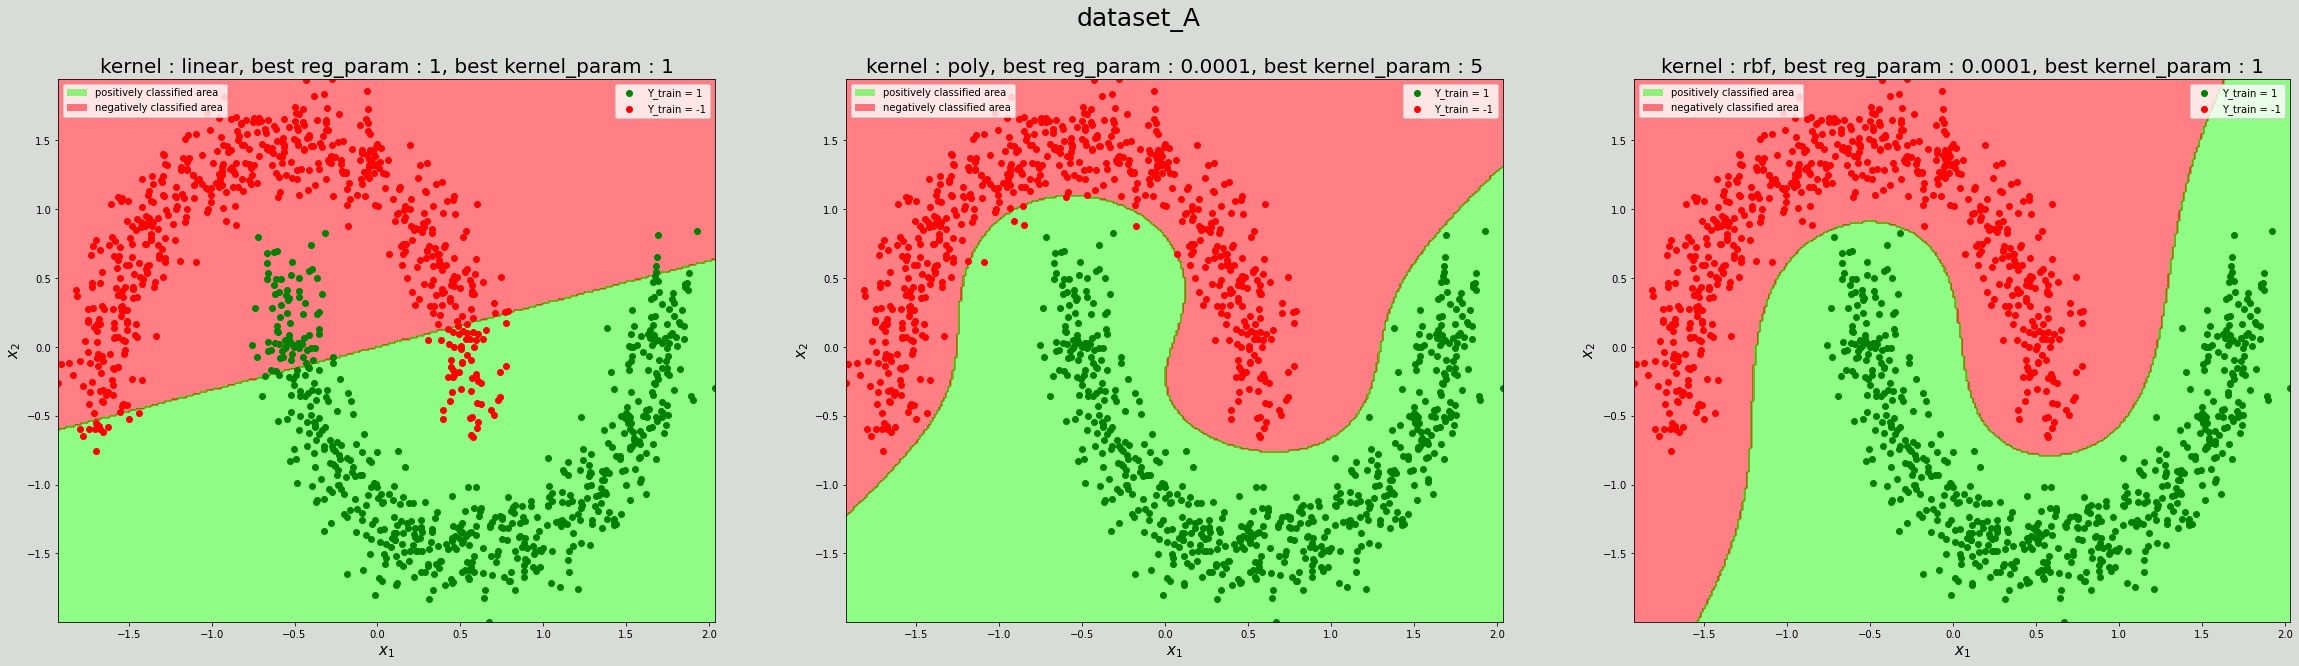

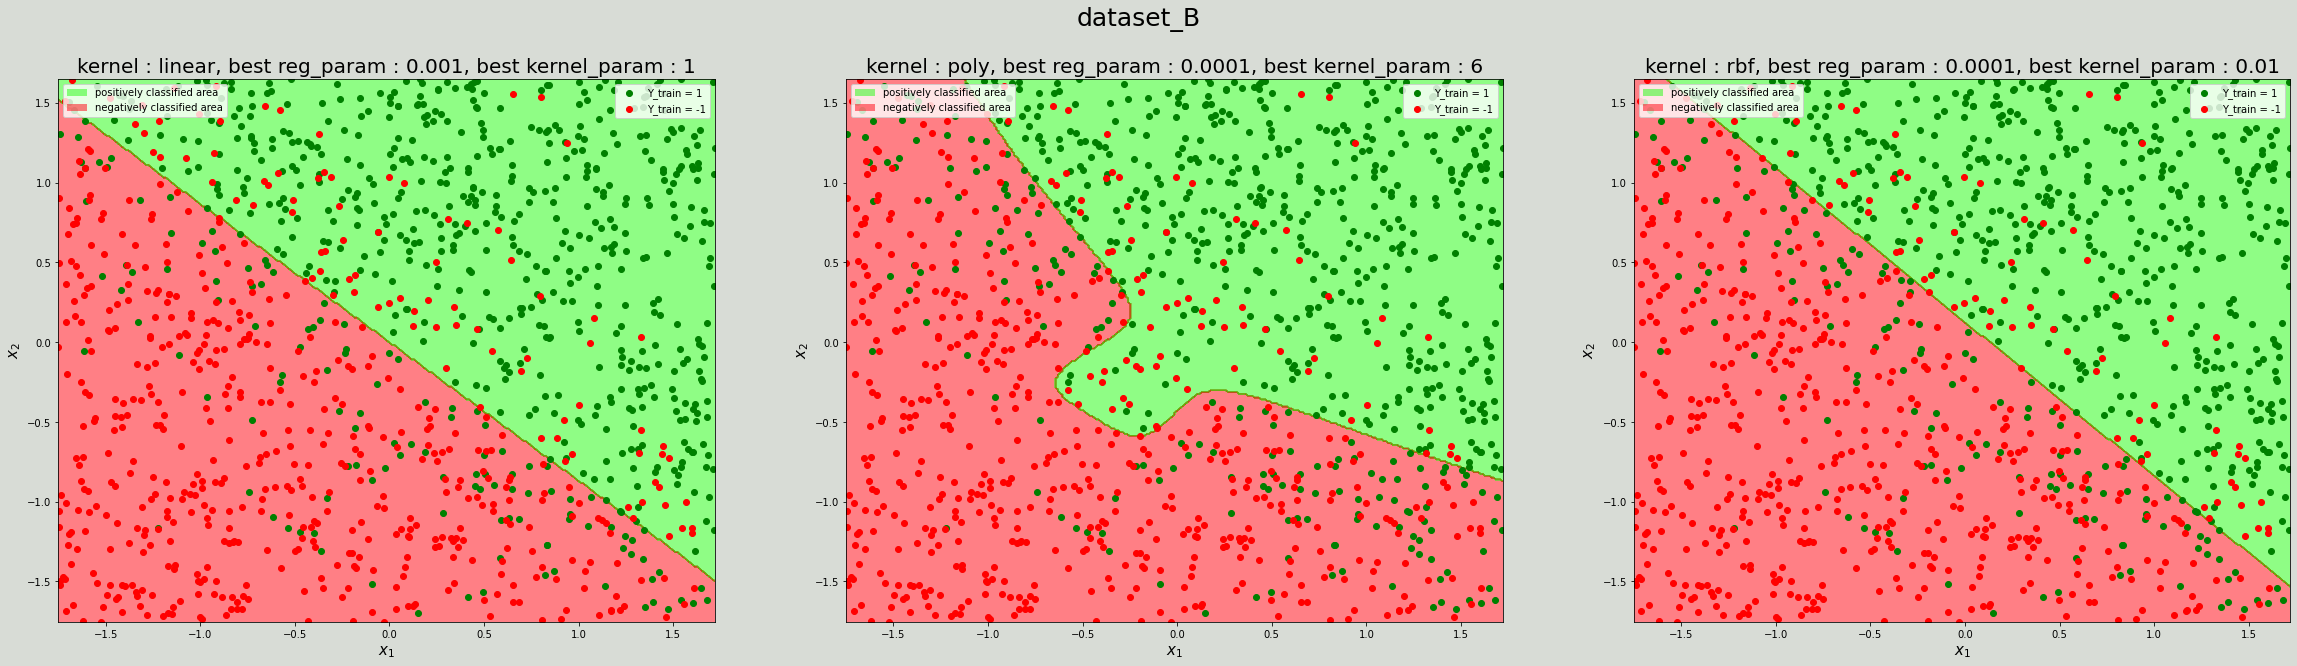

In [55]:
# Codewrite cell: Generate plots of learned classifier for all three kernel types, on dataset_A and datasset_B.
# Plots should give both the learned classifier and the train data. 
# Similar to  Bishop Figure 4.5 (with just two classes here.)
# Total number of plots = 3 * 2 = 6

kernel_type = {}
kernel_type[0] = 'linear'
kernel_type[1] = 'poly'
kernel_type[2] = 'rbf'

for i in range(2) :
    fig, ax = plt.subplots(1, 3)
    fig.set_size_inches(40, 10, forward = True)
    fig.suptitle("dataset_" + chr((ord('A') + i)), fontsize = 25)
    fig.set_facecolor('xkcd:light grey')

    X_train_pos = {}
    X_train_neg = {}
    X_train_pos[i] = X_train[i][Y_train[i] == 1]
    X_train_neg[i] = X_train[i][Y_train[i] == -1]

    xx, yy = np.meshgrid(np.linspace(X_train[i][:, 0].min(),  X_train[i][:, 0].max(), 300), np.linspace(X_train[i][:, 1].min(), X_train[i][:, 1].max(), 300))
    Za = test_pred(best_validated_alpha[('linear', i)], X_train[i], Y_train[i], np.c_[xx.ravel(), yy.ravel()], 'linear', best_parameters_logistic[('linear', i)][1])
    Zb = test_pred(best_validated_alpha[('poly', i)], X_train[i], Y_train[i], np.c_[xx.ravel(), yy.ravel()], 'poly', best_parameters_logistic[('poly', i)][1])
    Zc = test_pred(best_validated_alpha[('rbf', i)], X_train[i], Y_train[i], np.c_[xx.ravel(), yy.ravel()], 'rbf', best_parameters_logistic[('rbf', i)][1])
    Za = Za.reshape(xx.shape)
    Zb = Zb.reshape(xx.shape)
    Zc = Zc.reshape(xx.shape)
    CS0 = ax[0].contourf(xx, yy, Za, colors = ('xkcd:bright red', 'xkcd:electric green'), alpha = 0.5)
    CS1 = ax[1].contourf(xx, yy, Zb, colors = ('xkcd:bright red', 'xkcd:electric green'), alpha = 0.5)
    CS2 = ax[2].contourf(xx, yy, Zc, colors = ('xkcd:bright red', 'xkcd:electric green'), alpha = 0.5)
    legend = {}
    proxy0 = [plt.Rectangle((0,0),1,1,fc = pc.get_facecolor()[0]) for pc in CS0.collections]
    legend[0] = ax[0].legend(proxy0[::-1], ["positively classified area", "negatively classified area"], loc = "upper left")
    proxy1 = [plt.Rectangle((0,0),1,1,fc = pc.get_facecolor()[0]) for pc in CS1.collections]
    legend[1] = ax[1].legend(proxy1[::-1], ["positively classified area", "negatively classified area"], loc = "upper left")
    proxy2 = [plt.Rectangle((0,0),1,1,fc = pc.get_facecolor()[0]) for pc in CS2.collections]
    legend[2] = ax[2].legend(proxy2[::-1], ["positively classified area", "negatively classified area"], loc = "upper left")
    
    for j in range(3) :
        ax[j].scatter(X_train_pos[i][:, 0], X_train_pos[i][:, 1], color = 'g', label = 'Y_train = 1')
        ax[j].scatter(X_train_neg[i][:, 0], X_train_neg[i][:, 1], color = 'r', label = 'Y_train = -1')
        
    for j in range(3) :
        char = chr((ord('a') + j))
        ax[j].set_title("kernel : " + str(kernel_type[j]) + ", best reg_param : " + str(best_parameters_logistic[(kernel_type[j], i)][0]) + ", best kernel_param : " + str(best_parameters_logistic[(kernel_type[j], i)][1]), fontsize = 20)
        ax[j].set_xlabel("$x_1$", fontsize = 15)
        ax[j].set_ylabel("$x_2$", fontsize = 15)
        ax[j].legend(loc = 'upper right')
        ax[j].add_artist(legend[j])



# 2. SVM

Write code for learning SVM below. Also write code for choosing best hyperparameters for each kernel type. You may use sklearn.svm for this purpose. (use a part of training set as validation set)

Write code for running in the cell after (You may be asked to demonstrate your code during the viva using this cell.)

In text cell after that report the following numbers you get by running appropriate code:

For each classification data set report the best kernel and regularisation parameters for linear, RBF and Poly kernels. (Linear has no kernel parameter.) Report the training and test zero-one error for those hyperparameters.

For the synthetic classification datasets in 2-dimensions, also illustrate the learned classifier for each kernel setting. Do this in the last codeWrite cell for this question.

In [56]:
# CodeWrite cell
# Write SVM classifier using SKlearn
# write only functions here
def train_svm(X, Y, kernel, reg_param, kernel_param):
    if kernel == 'linear':
        classif_algo = svm.SVC(C=reg_param, kernel=kernel)
    elif kernel == 'poly':
        classif_algo = svm.SVC(C=reg_param, kernel=kernel, degree = kernel_param, gamma = 1, coef0 = 1)
    else:
        classif_algo = svm.SVC(C=reg_param, kernel=kernel, gamma = kernel_param)
    classifier = classif_algo.fit(X,Y)
    return classifier

def test_pred_svm(classifier, test_X, kernel, kernel_param):
    prediction = classifier.predict(test_X) 
    return prediction.reshape(prediction.shape[0])
  

In [57]:
# CodeWrite cell
# Write code here for doing validation (for kernel_param and regularisation_param)
# on a subset of the training set. 
# Also for generating the numbers that you report below.
dataset = {}
dataset[0] = np.load('../../Data/dataset_A.npz')
dataset[1] = np.load('../../Data/dataset_B.npz')
dataset[2] = np.load('../../Data/dataset_C.npz')
dataset[3] = np.load('../../Data/dataset_D.npz')

X = {}
Y = {}
X_test = {}
Y_test = {}
X_hold_out = {}
Y_hold_out = {}
X_train = {}
Y_train = {}

for i in range(4) :
    X[i] = dataset[i]['arr_0']
    Y[i] = dataset[i]['arr_1']
    X_test[i] = dataset[i]['arr_2']
    Y_test[i] = dataset[i]['arr_3']

for i in range(4) : 
    X_train[i], Y_train[i], X_hold_out[i], Y_hold_out[i] = train_holdout_split(X[i], Y[i])

for i in range(4) : 
    X_train[i], X_test[i], X_hold_out[i] = normalize_data(X_train[i], X_hold_out[i], X_test[i])

best_parameters_svm = {}
best_validated_classifier = {}
for i in range(4) :
    for kernel in ['linear', 'poly', 'rbf'] :
        min_error = np.inf
        for reg_param in [1e-7, 1e-6, 1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2] :
            if kernel == 'linear' :
                kernel_param = 1
                svc = train_svm(X_train[i], Y_train[i], kernel, reg_param, kernel_param)
                pred = test_pred_svm(svc, X_hold_out[i], kernel, kernel_param)
                validation_error = mis_classification_error(pred, Y_hold_out[i])
                if validation_error < min_error :
                    min_error = validation_error
                    best_parameters_svm[(kernel, i)] = [reg_param, kernel_param]
                    best_validated_classifier[(kernel, i)] = svc
            if kernel == 'poly' :
                for kernel_param in [1, 2, 3, 4, 5, 6, 7] :
                    svc = train_svm(X_train[i], Y_train[i], kernel, reg_param, kernel_param)
                    pred = test_pred_svm(svc, X_hold_out[i], kernel, kernel_param)
                    validation_error = mis_classification_error(pred, Y_hold_out[i])
                    if validation_error < min_error :
                        min_error = validation_error
                        best_parameters_svm[(kernel, i)] = [reg_param, kernel_param]
                        best_validated_classifier[(kernel, i)] = svc
            if kernel == 'rbf' :
                for kernel_param in [1e-7, 1e-6, 1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2] :
                    svc = train_svm(X_train[i], Y_train[i], kernel, reg_param, kernel_param)
                    pred = test_pred_svm(svc, X_hold_out[i], kernel, kernel_param)
                    validation_error = mis_classification_error(pred, Y_hold_out[i])
                    if validation_error < min_error :
                        min_error = validation_error
                        best_parameters_svm[(kernel, i)] = [reg_param, kernel_param]
                        best_validated_classifier[(kernel, i)] = svc

svm_error = {}
for i in range(4) :
    for kernel in ['linear', 'poly', 'rbf'] :
        svc = best_validated_classifier[(kernel, i)]
        kernel_param = best_parameters_svm[(kernel, i)][1]
        test_set_pred = test_pred_svm(svc, X_test[i], kernel, kernel_param)
        validation_pred = test_pred_svm(svc, X_hold_out[i], kernel, kernel_param)
        train_pred = test_pred_svm(svc, X_train[i], kernel, kernel_param)
        test_error = mis_classification_error(test_set_pred, Y_test[i])
        validation_error = mis_classification_error(validation_pred, Y_hold_out[i])
        train_error = mis_classification_error(train_pred, Y_train[i])
        svm_error[(kernel, i)] = {'train error' : train_error, 'test error' : test_error, 'validation error' : validation_error}
    


TextWrite cell: Give your observations and the list of hyperparameter choices and train zero-one error  and test zero-one error, for all 4 datasets (2 real world and 2 synthetic). 

### Observations
#### dataset_A 
* We can note that the dataset is separable by a non-linear boundary, because of this, both the rbf and polynomial kernels which can produce classifiers with non-linear decision boundaries perform very well and are able to clearly separate
the two classes whereas the linear kernel which produces a linear decision boundary, performs much worse.
#### dataset_B
* Here, the dataset is not linearly separable and there is a lot of overlap between the supports of the two classes. Furthermore, all three types of classifiers
which use the linear, rbf and polynomial kernels output almost the same decision boundary i.e. the diagonal separating the two classes. Thus the zero-one error for all
three classifiers are approximately the same
#### dataset_C
* Although we cannot plot the data for visualization, from the performance of the three datasets, we can get to know that the dataset is not linearly separable. 
The linear kernel classifier performs very badly as compared to the rbf and the polynomial kernel classfiers. 
#### dataset_D 
* Here, we can infer from the very small zero-one errors on classifiers output by the linear kernel classifier that the dataset is linearly separable, therefore, all three kernel based classifiers
perform very well on this dataset.

#### General Observations about SVM and Logistic Regression
* We can also note that the performance of the SVM classifiers are only marginally better than the classifiers learnt using logistic regression. This can be attributed to 
the better technqiues used by sklearn to compute the optima of the dual SVM problem. It could also be attributed to the fact that the SVM algorithm (in general) computes the 
hard margin classifier and therefore generalizes better than logistic regression. 

### Hyperparamters and Test/Train errors 

|dataset_A|reg_param|kernel_param|train error|test error|
|-|-|-|-|-|
|linear|1|1|0.127|0.132|
|poly|0.01|4|0.0017|0.004|
|rbf|0.1|10.0|0.00083|0.002|

|dataset_B|reg_param|kernel_param|train error|test error|
|-|-|-|-|-|
|linear|0.1|1|0.17|0.196|
|poly|0.1|1|0.17|0.196|
|rbf|100.0|0.001|0.169|0.196|

|dataset_C|reg_param|kernel_param|train error|test error|
|-|-|-|-|-|
|linear|100.0|1|0.0558|0.104|
|poly|1e-7|3|0.0|0.0134|
|rbf|10.0|0.001|0.0|0.0168|

|dataset_D|reg_param|kernel_param|train error|test error|
|-|-|-|-|-|
|linear|0.001|1|0.06875|0.0295|
|poly|0.001|3|0.003125|0.0177|
|rbf|0.1|0.01|0.072|0.0355|


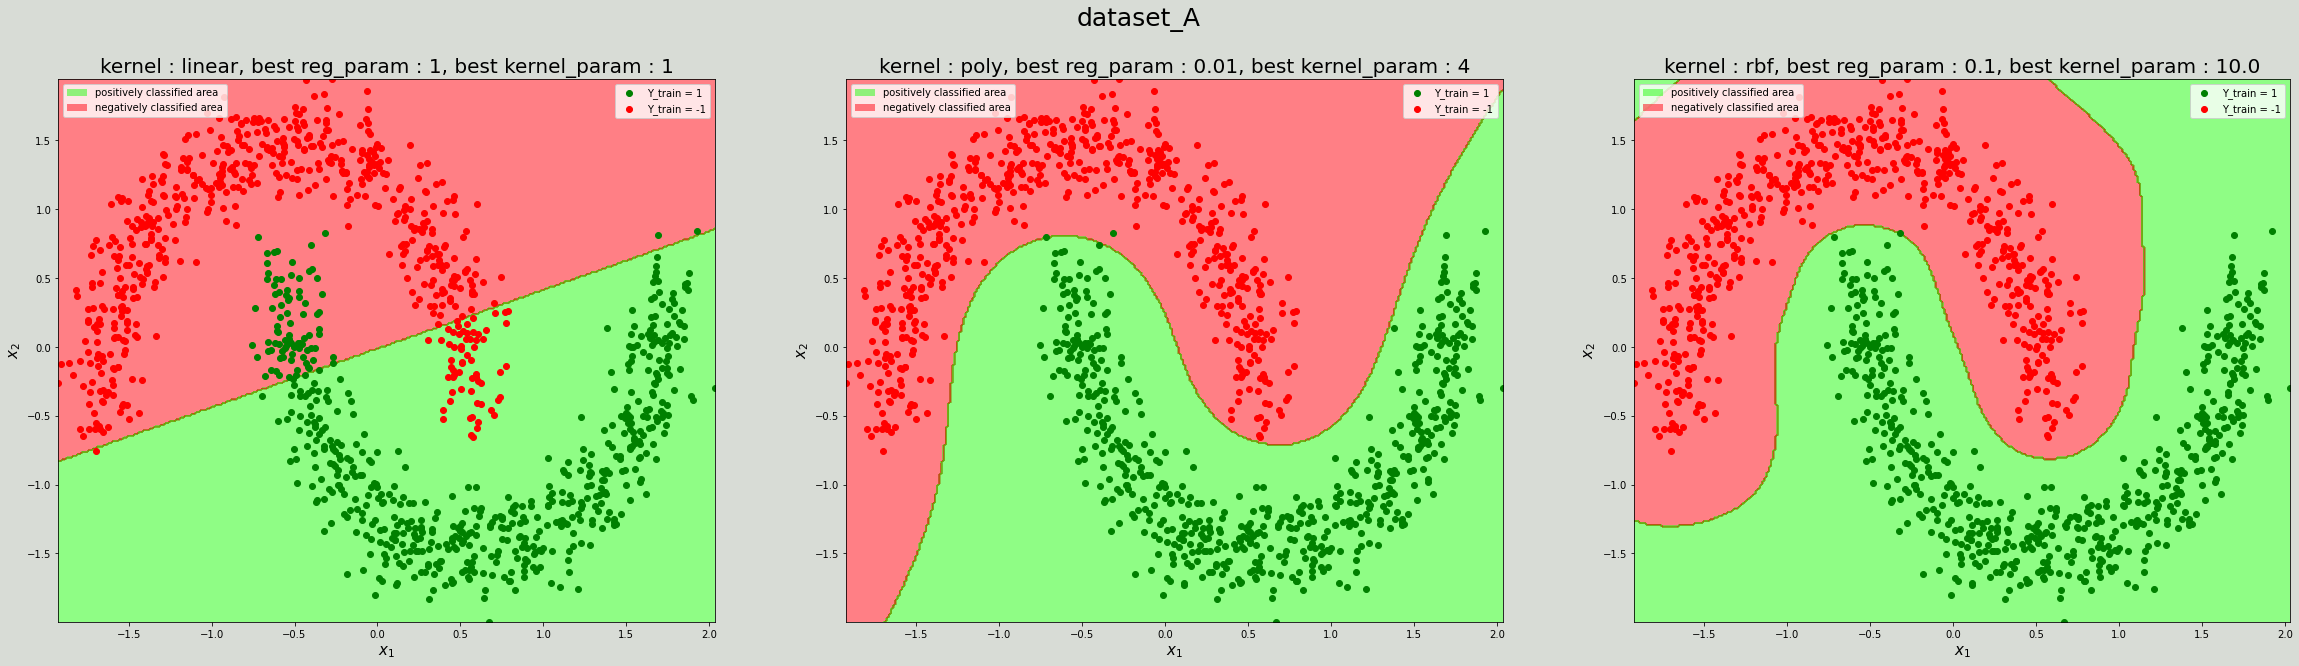

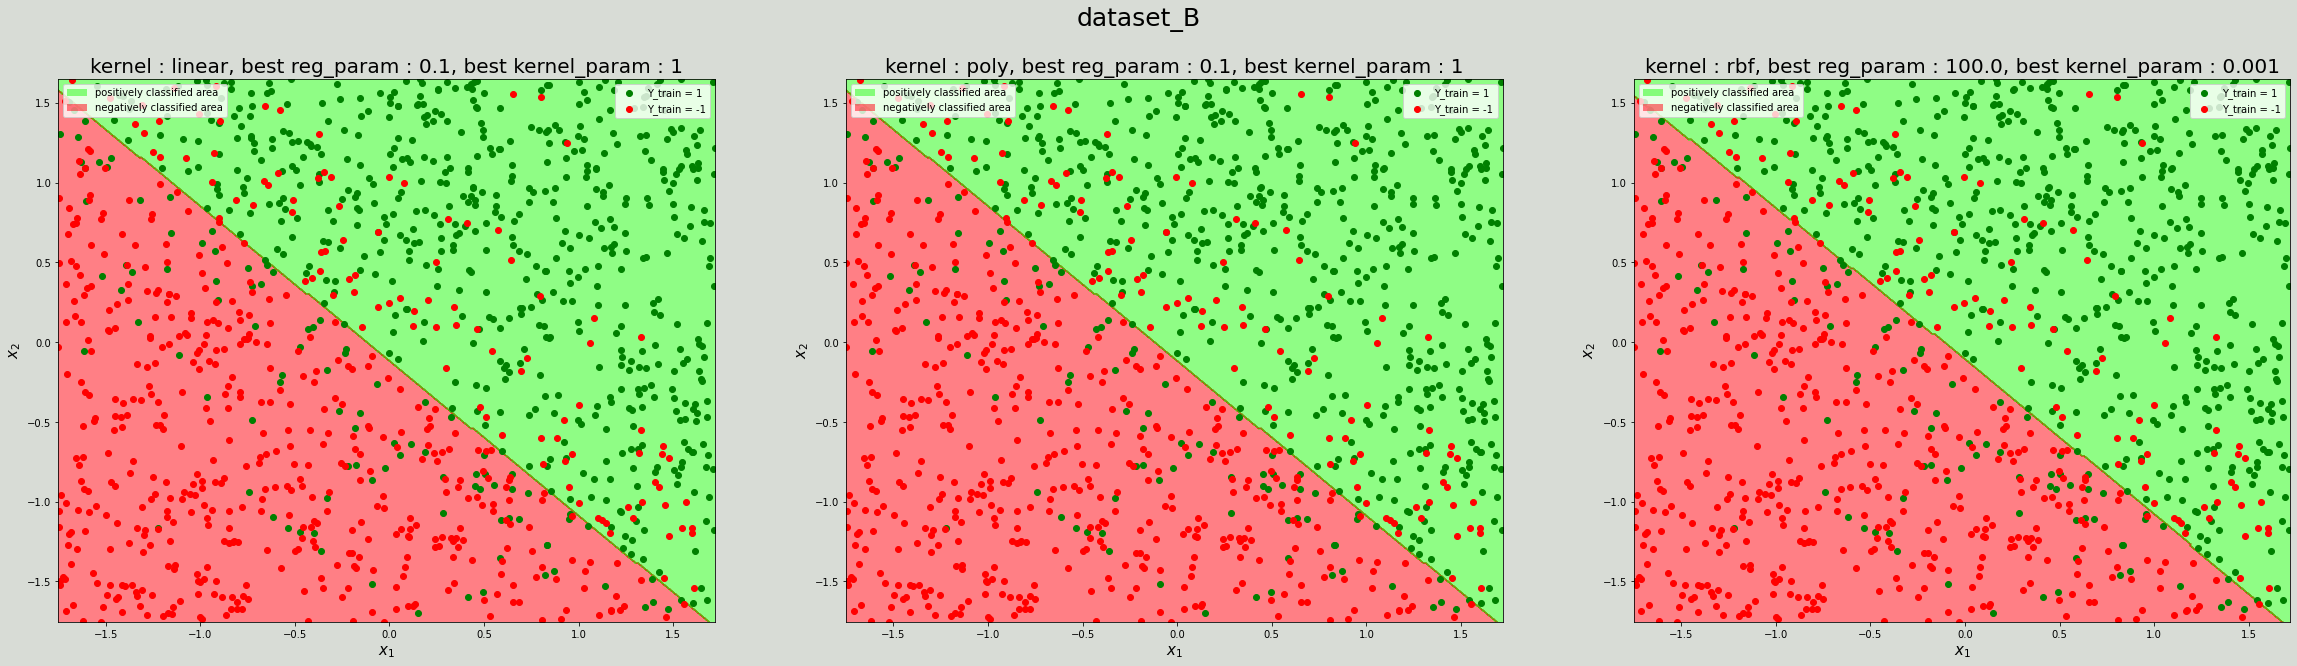

In [59]:
# Codewrite cell: Generate plots of learned classifier for all three kernel types, on dataset_A and datasset_B.
# Plots should give both the learned classifier and the train data. 
# Similar to  Bishop Figure 4.5 (with just two classes here.)
# Total number of plots = 3 * 2 = 6
for i in range(2) :
    fig, ax = plt.subplots(1, 3)
    fig.set_size_inches(40, 10, forward = True)
    fig.suptitle("dataset_" + chr((ord('A') + i)), fontsize = 25)
    fig.set_facecolor('xkcd:light grey')

    X_train_pos = {}
    X_train_neg = {}
    X_train_pos[i] = X_train[i][Y_train[i] == 1]
    X_train_neg[i] = X_train[i][Y_train[i] == -1]

    x_min, x_max = X_train[i][:, 0].min() - 1, X_train[i][:, 0].max() + 1
    y_min, y_max = X_train[i][:, 1].min() - 1, X_train[i][:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05), np.arange(y_min, y_max, 0.05))
    xx, yy = np.meshgrid(np.linspace(X_train[i][:, 0].min(),  X_train[i][:, 0].max(), 300), np.linspace(X_train[i][:, 1].min(), X_train[i][:, 1].max(), 300))
    Za = test_pred_svm(best_validated_classifier[('linear', i)], np.c_[xx.ravel(), yy.ravel()], 'linear', best_parameters_svm[('linear', i)][1])
    Zb = test_pred_svm(best_validated_classifier[('poly', i)], np.c_[xx.ravel(), yy.ravel()], 'poly', best_parameters_svm[('poly', i)][1])
    Zc = test_pred_svm(best_validated_classifier[('rbf', i)], np.c_[xx.ravel(), yy.ravel()], 'rbf', best_parameters_svm[('rbf', i)][1])
    Za = Za.reshape(xx.shape)
    Zb = Zb.reshape(xx.shape)
    Zc = Zc.reshape(xx.shape)
    CS0 = ax[0].contourf(xx, yy, Za, colors = ('xkcd:bright red', 'xkcd:electric green'), alpha = 0.5)
    CS1 = ax[1].contourf(xx, yy, Zb, colors = ('xkcd:bright red', 'xkcd:electric green'), alpha = 0.5)
    CS2 = ax[2].contourf(xx, yy, Zc, colors = ('xkcd:bright red', 'xkcd:electric green'), alpha = 0.5)
    legend = {}
    proxy0 = [plt.Rectangle((0,0),1,1,fc = pc.get_facecolor()[0]) for pc in CS0.collections]
    legend[0] = ax[0].legend(proxy0[::-1], ["positively classified area", "negatively classified area"], loc = "upper left")
    proxy1 = [plt.Rectangle((0,0),1,1,fc = pc.get_facecolor()[0]) for pc in CS1.collections]
    legend[1] = ax[1].legend(proxy1[::-1], ["positively classified area", "negatively classified area"], loc = "upper left")
    proxy2 = [plt.Rectangle((0,0),1,1,fc = pc.get_facecolor()[0]) for pc in CS2.collections]
    legend[2] = ax[2].legend(proxy2[::-1], ["positively classified area", "negatively classified area"], loc = "upper left")
    
    for j in range(3) :
        ax[j].scatter(X_train_pos[i][:, 0], X_train_pos[i][:, 1], color = 'g', label = 'Y_train = 1')
        ax[j].scatter(X_train_neg[i][:, 0], X_train_neg[i][:, 1], color = 'r', label = 'Y_train = -1')
        
    for j in range(3) :
        char = chr((ord('a') + j))
        ax[j].set_title("kernel : " + str(kernel_type[j]) + ", best reg_param : " + str(best_parameters_svm[(kernel_type[j], i)][0]) + ", best kernel_param : " + str(best_parameters_svm[(kernel_type[j], i)][1]), fontsize = 20)
        ax[j].set_xlabel("$x_1$", fontsize = 15)
        ax[j].set_ylabel("$x_2$", fontsize = 15)
        ax[j].legend()
        ax[j].add_artist(legend[j])

# 3. Decision Tree

Write code for learning decision tree below. Take as an argument a hyperparameter on what size node to stop splitting. Use a part of training set as validation set.

Write code for running in the cell after (You may be asked to demonstrate your code during the viva using this cell.)

In text cell after that report the following numbers you get by running appropriate code:

For all four data sets  report the best node size to stop splitting. Report the training and test zero-one error for those hyperparameters.

For datasets A and B, also illustrate the learned classifier. Do this in the last codeWrite cell for this question.

Important: Think about how you will represent a decision tree. (Possible soln: Store as a list of tuples containing node position, attribute to split, threshold, class to classifiy (if leaf node) )


In [4]:
# CodeWrite cell
# Write Decision tree classifier from scratch, 
# write only functions here (you may write extra functions here if you wish)

def list_of_splits(X_train_i, n_splits = 10):
    mi = min(X_train_i)
    ma = max(X_train_i)
    if mi == ma:
        splits = np.array([])
    else:
        splits = np.linspace(mi, ma, n_splits)[1:-1]
    return splits

def h(x):
    if (x == 0) or (x == 1) :
        return 0
    return x * np.log(1/x) + (1 - x) * np.log(1/(1 - x))
    
# flag = 0 indicates that marking the data set on the right of the split as y = 1 makes more sense
# flag = 1 indicates that marking the data set on the left of the split as y = 1 makes more sense
def criterion_for_split(split, criterion, X_i, Y_train):
    """
    if X_i[X_i < split].shape[0] == 0 or X_i[X_i >= split].shape[0] == 0 :
    return (1, 0)  # these points will essentially not be considered as a candidate for the best_split
    """
    Y_prediction = (X_i >= split)
    Y_prediction = Y_prediction.astype(int)
    Y_prediction[Y_prediction == 0] = -1
    accuracy = Y_prediction[Y_prediction != Y_train].shape[0]/Y_train.shape[0]
    accuracy = max(accuracy, 1 - accuracy)    
    if criterion == 'accuracy' :    
        return accuracy
    elif criterion == 'entropy' :
        pl = np.sum(X_i < split)/X_i.shape[0]
        ql = np.sum(Y_train[X_i < split] == 1)/Y_train[X_i < split].shape[0]
        pr = np.sum(X_i >= split)/X_i.shape[0]
        qr = np.sum(Y_train[X_i >= split] == 1)/Y_train[X_i >= split].shape[0]
        entropy = pl * h(ql) + pr * h(qr)
        return entropy

def condition(X_train, Y_train, criterion):
    best = np.zeros(2)
    n = X_train.shape[0]
    d = X_train.shape[1]
    if criterion == 'accuracy' :
        m_criterion = 0
    elif criterion == 'entropy' :
        m_criterion = np.inf
    for i in range(d) :
        listofsplits = list_of_splits(X_train[:, i])
        for split in listofsplits:
            v_criterion = criterion_for_split(split, criterion, X_train[:, i], Y_train)
            if criterion == 'accuracy' :
                if v_criterion > m_criterion :
                    m_criterion = v_criterion
                    best = np.array([split, i])
            elif criterion == 'entropy' :
                if v_criterion < m_criterion :
                    m_criterion = v_criterion
                    best = np.array([split, i])
    return best

def train_decision_tree_h(X, Y, num_nodes_stop, criterion, nodeid, tree):
    n = X.shape[0]
    # check if the same point has been repeated
    pos = Y[Y == 1].shape[0]/Y.shape[0]
    if pos == 1 :
        tree[nodeid] = np.array([None, None, 1]) # prediction is 1 
        return tree
    elif pos == 0 : 
        tree[nodeid] = np.array([None, None, -1]) # prediction is -1
        return tree
    best = condition(X, Y, criterion)
    split, i = best
    best = np.append(best, 0) # for leaves, contains the predicted colour.
    tree[nodeid] = best
    if n <= num_nodes_stop :
        if pos >= 0.5 :
            tree[nodeid][2] = 1 # prediction is 1 
        else : 
            tree[nodeid][2] = -1 # prediction is 0
    else :
        nodeidl = 2 * nodeid
        nodeidr = 2 * nodeid + 1
        Xi = X[:, int(i)]
        tree = train_decision_tree_h(X[Xi >= split], Y[Xi >= split], num_nodes_stop, criterion, nodeidr, tree)
        tree = train_decision_tree_h(X[Xi < split], Y[Xi < split], num_nodes_stop, criterion, nodeidl, tree)
    return tree

def train_decision_tree(X, Y, num_nodes_stop=1, criterion='accuracy'):
    """ Returns a decision tree trained on X and Y. 
    Stops splitting nodes when a node has hit a size of "num_nodes_stop" or lower.
    Split criterion can be either 'accuracy' or 'entropy'.
    Returns a tree (In whatever format that you find appropriate)
    """
    tree = {}
    tree = train_decision_tree_h(X, Y, num_nodes_stop, criterion, 1, tree)
    return tree

def eval_decision_tree_h(tree, nodeid, test_X_instance):
    if tree[nodeid][2] != 0 :
        return tree[nodeid][2]
    else :
        split, i = tree[nodeid][:-1] 
        check = test_X_instance[int(i)] >= split
        if check == 1 :
            return eval_decision_tree_h(tree, 2 * nodeid + 1, test_X_instance)
        else :
            return eval_decision_tree_h(tree, 2 * nodeid, test_X_instance)

def eval_decision_tree(tree, test_X):
    """ Takes in a tree, and a bunch of instances X and 
    returns the tree predicted values at those instances."""
    Y_pred = np.asarray([eval_decision_tree_h(tree, 1, test_X_instance) for test_X_instance in test_X])
    return Y_pred


In [61]:
# CodeWrite cell
# Write code here for doing validation to find the best hyperparameters (i.e. num_nodes_stop)
# Also Generate the numbers that you report below. 
# Repeat with criterion set to entropy also.
dataset = {}
dataset[0] = np.load('../../Data/dataset_A.npz')
dataset[1] = np.load('../../Data/dataset_B.npz')
dataset[2] = np.load('../../Data/dataset_C.npz')
dataset[3] = np.load('../../Data/dataset_D.npz')

X = {}
Y = {}
X_test = {}
Y_test = {}
X_hold_out = {}
Y_hold_out = {}
X_train = {}
Y_train = {}

for i in range(4) :
    X[i] = dataset[i]['arr_0']
    Y[i] = dataset[i]['arr_1']
    X_test[i] = dataset[i]['arr_2']
    Y_test[i] = dataset[i]['arr_3']

for i in range(4) : 
    X_train[i], Y_train[i], X_hold_out[i], Y_hold_out[i] = train_holdout_split(X[i], Y[i])

best_parameters_tree = {}
best_validated_tree = {}
for i in range(4) :
    for criterion in ['accuracy', 'entropy'] :
        min_error = np.inf
        for num_nodes_stop in [1, 2, 4, 8, 16, 32] :
            tree = train_decision_tree(X_train[i], Y_train[i], num_nodes_stop, criterion)
            pred = eval_decision_tree(tree, X_hold_out[i])
            validation_error = mis_classification_error(pred, Y_hold_out[i])
            if validation_error < min_error :
                min_error = validation_error
                best_parameters_tree[(criterion, i)] = num_nodes_stop
                best_validated_tree[(criterion, i)] = tree

decision_tree_error = {}
for i in range(4) :
    for criterion in ['accuracy', 'entropy'] :
        tree = best_validated_tree[(criterion, i)]
        test_set_pred = eval_decision_tree(tree, X_test[i])
        validation_pred = eval_decision_tree(tree, X_hold_out[i])
        train_pred = eval_decision_tree(tree, X_train[i])
        test_error = mis_classification_error(test_set_pred, Y_test[i])
        validation_error = mis_classification_error(validation_pred, Y_hold_out[i])
        train_error = mis_classification_error(train_pred, Y_train[i])
        decision_tree_error[(criterion, i)] = {'train error' : train_error, 'test error' : test_error, 'validation error' : validation_error}
    

TextWrite cell: Give your observations and the list of hyperparameter choices and train zero-one error  and test zero-one error, for all 4 datasets (2 real world and 2 synthetic). 

### Observations

* In general, entropy tends to be a better split criterion than accuracy. This can be observed from the smaller test and train errors for the entropy criterion
as compared to the accuracy criterion (in most cases). 
* In case of dataset_B, we see that the best num_nodes_stop criterions are much larger than in the other cases. This indicates that the dataset is prone to overfitting on smaller values of num_nodes_stop. 
This can also be seen from the scatter plot, there is a lot of overlap between the two classes and therefore, too "strong" a model (like a decision tree with num_nodes_stop = 1) will lead to overfitting. 
* On comparing the SVM with the decision tree based approach, we observe that the train errors are very less with decision trees i.e. it is a very powerful
and expressive model, but as is the case with most such models, it is prone to overfitting. This is also evident from the test set performance of decision trees
as compared to SVMs where the decision trees fail to generalize well. This failure to generalize (as compared to SVM) is more pronounced in dataset_C and dataset_D. 
Therefore, for these datasets, a random forest based approach can be expected to yield better results than a pure decision tree. 

### Train and Test errors and Hyperparameter choices
num_nodes_stop hyperparameter was chosen based on validation set performance. The values that were tried out are 
num_nodes_stop = $\{1, 2, 4, 8, 16, 32\}$. 

The following tables show the value of the num_nodes_stop hyperparameter chosen and the corresponding train and test errors for the various datasets on the accuracy and entropy criterion. 

#### Train and Test errors
##### Accuracy

|dataset|train error|test error|
|-|-|-|
|**dataset_A**|0.01416|0.038|
|**dataset_B**|0.15583|0.196| 
|**dataset_C**|0.1|0.111|
|**dataset_D**|0.0219|0.071|

##### Entropy

|dataset|train error|test error|
|-|-|-|
|**dataset_A**|0.0|0.006|
|**dataset_B**|0.1359|0.238| 
|**dataset_C**|0.0|0.0875|
|**dataset_D**|0.0|0.0769|

##### Best num_nodes_stop size

|dataset|accuracy|entropy|
|-|-|-|
|**dataset_A**|4|1|
|**dataset_B**|32|16|
|**dataset_C**|32|1|
|**dataset_D**|4|1|



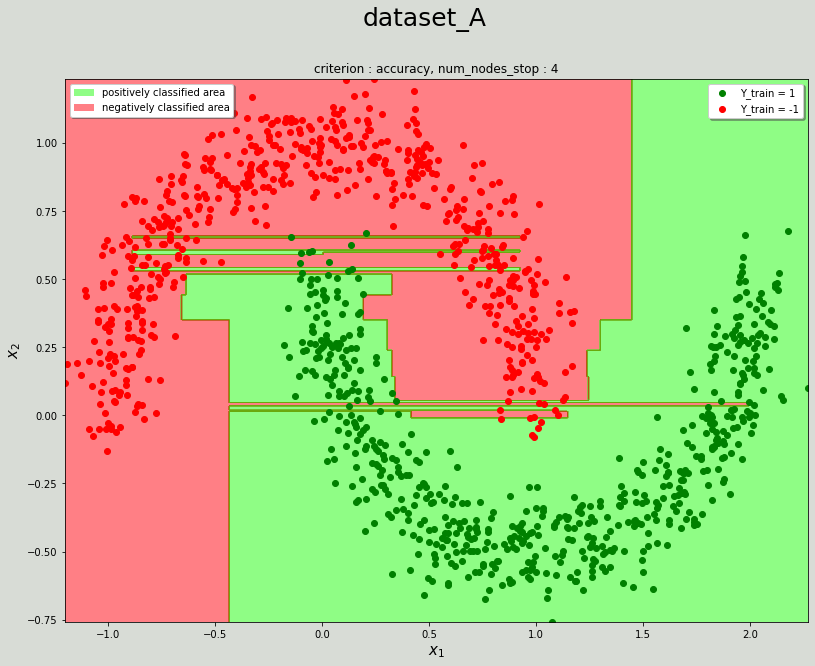

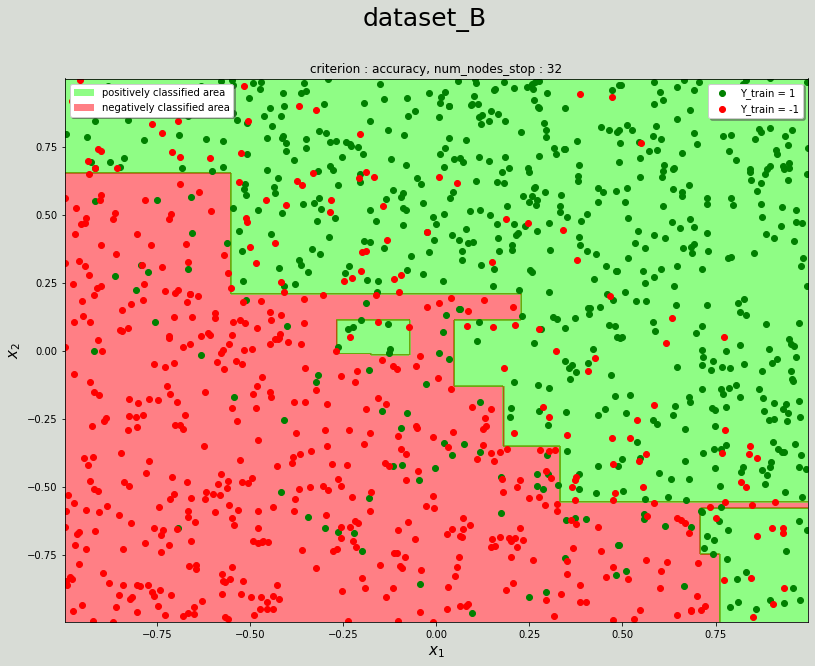

In [63]:
## Codewrite cell: Generate plots of learned decision tree classifier on dataset_A and datasset_B.
# Plots should give both the learned classifier and the train data. 
# Plots only required for the accuracy criterion.
# Similar to  Bishop Figure 4.5 (with just two classes here.)
# Total number of plots = 2 
for i in range(2) :
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(13.33, 10, forward = True)
    fig.suptitle("dataset_" + chr((ord('A') + i)), fontsize = 25)
    fig.set_facecolor('xkcd:light grey')

    X_train_pos = {}
    X_train_neg = {}
    X_train_pos[i] = X_train[i][Y_train[i] == 1]
    X_train_neg[i] = X_train[i][Y_train[i] == -1]

    xx, yy = np.meshgrid(np.linspace(X_train[i][:, 0].min(), X_train[i][:, 0].max(), 500), np.linspace(X_train[i][:, 1].min(), X_train[i][:, 1].max(), 500))
    Za = eval_decision_tree(best_validated_tree[('accuracy', i)], np.c_[xx.ravel(), yy.ravel()])
    Za = Za.reshape(xx.shape)
    CS = ax.contourf(xx, yy, Za, colors = ('xkcd:bright red', 'xkcd:electric green'), alpha = 0.5)
    proxy = [plt.Rectangle((0,0),1,1,fc = pc.get_facecolor()[0]) for pc in CS.collections]
    legend = ax.legend(proxy[::-1], ["positively classified area", "negatively classified area"], loc = "upper left", fancybox = True, shadow = True)
    
    ax.scatter(X_train_pos[i][:, 0], X_train_pos[i][:, 1], color = 'g', label = 'Y_train = 1')
    ax.scatter(X_train_neg[i][:, 0], X_train_neg[i][:, 1], color = 'r', label = 'Y_train = -1')
        
    ax.set_title("criterion : " + "accuracy" + ", num_nodes_stop : " + str(best_parameters_tree[('accuracy', i)]))
    ax.set_xlabel("$x_1$", fontsize = 15)
    ax.set_ylabel("$x_2$", fontsize = 15)
    ax.legend(loc = 'upper right', fancybox = True, shadow = True)
    ax.add_artist(legend)



# 4 Random Forest classifier

Write code for learning RandomForests below. Fix the following hyper parameters: (Fraction of data to learn tree=0.5, Fraction of number of features chosen in each node=0.5, num_nodes_stop=1).  Choose the number of trees to add in the forest by using a validation set. You may use a slightly modified version of the decision tree code you had written earlier.

Write code for running in the cell after the nest. (You may be asked to demonstrate your code during the viva using this cell.) 

In text cell after that report the following numbers you get by running appropriate code:

For all 4 data sets (A,B,C,D)  report the best number of trees found. Report the training and test zero-one error for those hyperparameters.

For the synthetic classification datasets (datasets A and B) in 2-dimensions, also illustrate the learned classifier for each kernel setting. Do this in the last codeWrite cell for this question.

In [5]:
# CodeWrite cell
# Write Random Forest classifier. 
def condition_forest(X_train, Y_train, criterion, b):
    best = np.zeros(2)
    n = X_train.shape[0]
    d = X_train.shape[1]
    if criterion == 'accuracy' :
        m_criterion = 0
    elif criterion == 'entropy' :
        m_criterion = np.inf
    permutation = np.random.permutation(d) - 1
    selection = permutation[:int(d*b)]
    for i in selection :
        listofsplits = list_of_splits(X_train[:, i])
        for split in listofsplits:
            v_criterion = criterion_for_split(split, criterion, X_train[:, i], Y_train)
            if criterion == 'accuracy' :
                if v_criterion > m_criterion :
                    m_criterion = v_criterion
                    best = np.array([split, i])
            elif criterion == 'entropy' :
                if v_criterion < m_criterion :
                    m_criterion = v_criterion
                    best = np.array([split, i])
    return best

def train_decision_tree_forest_h(X, Y, num_nodes_stop, criterion, nodeid, tree, b):
    n = X.shape[0]
    # check if the same point has been repeated
    pos = Y[Y == 1].shape[0]/Y.shape[0]
    if pos == 1 :
        tree[nodeid] = np.array([None, None, 1]) # prediction is 1 
        return tree
    elif pos == 0 : 
        tree[nodeid] = np.array([None, None, -1]) # prediction is -1
        return tree
    best = condition_forest(X, Y, criterion, b)
    split, i = best
    best = np.append(best, 0) # for leaves, contains the predicted colour.
    tree[nodeid] = best
    if n <= num_nodes_stop :
        if pos >= 0.5 :
            tree[nodeid][2] = 1 # prediction is 1 
        else : 
            tree[nodeid][2] = -1 # prediction is 0
    else :
        nodeidl = 2 * nodeid
        nodeidr = 2 * nodeid + 1
        Xi = X[:, int(i)]
        tree = train_decision_tree_forest_h(X[Xi >= split], Y[Xi >= split], num_nodes_stop, criterion, nodeidr, tree)
        tree = train_decision_tree_forest_h(X[Xi < split], Y[Xi < split], num_nodes_stop, criterion, nodeidl, tree)
    return tree

def train_decision_tree_forest(X, Y, b, num_nodes_stop=1, criterion='accuracy'):
    """ Returns a decision tree trained on X and Y. 
    Stops splitting nodes when a node has hit a size of "num_nodes_stop" or lower.
    Split criterion can be either 'accuracy' or 'entropy'.
    Returns a tree (In whatever format that you find appropriate)
    """
    tree = {}
    tree = train_decision_tree_h(X, Y, num_nodes_stop, criterion, 1, tree)
    return tree

def train_random_forest(X, Y, num_trees=10, num_nodes_stop=1, 
                        criterion='accuracy', a=0.5, b=0.5):
    """ Returns a random forest trained on X and Y. 
    Trains num_trees.
    Stops splitting nodes in each tree when a node has hit a size of "num_nodes_stop" or lower.
    Split criterion can be either 'accuracy' or 'entropy'.
    Fraction of data used per tree = a
    Fraction of features used in each node = b
    Returns a random forest (In whatever format that you find appropriate)
    """
    random_forest = np.array([])
    n = X.shape[0]
    for i in range(num_trees) :
        selection = np.random.choice(n, int(n*a), replace = False)
        X_train, Y_train = X[selection], Y[selection]
        tree = train_decision_tree_forest(X_train, Y_train, b, num_nodes_stop, criterion)
        random_forest = np.append(random_forest, tree)
    return random_forest

def eval_random_forest(random_forest, test_X):
    """ Takes in a  random forest object (hhowever you want to store it), and a bunch of instances X and 
    returns the tree predicted values at those instances."""
    predictions = np.zeros((test_X.shape[0], random_forest.shape[0]))
    for i in range(random_forest.shape[0]) :
        predictions[:, i] = eval_decision_tree(random_forest[i], test_X)
    final_pred = np.sign(np.sum(predictions, axis = 1))
    final_pred[final_pred == 0] = 1
    return final_pred



In [7]:
# CodeWrite cell
# Write code for choosing the best hyperparameters (num_trees, num_nodes_stop)
# Write code here for generating the numbers that you report below.
# Repeat above for criterion set to entropy also.
dataset = {}
dataset[0] = np.load('../../Data/dataset_A.npz')
dataset[1] = np.load('../../Data/dataset_B.npz')
dataset[2] = np.load('../../Data/dataset_C.npz')
dataset[3] = np.load('../../Data/dataset_D.npz')


X = {}
Y = {}
X_test = {}
Y_test = {}
X_hold_out = {}
Y_hold_out = {}
X_train = {}
Y_train = {}

for i in range(4) :
    X[i] = dataset[i]['arr_0']
    Y[i] = dataset[i]['arr_1']
    X_test[i] = dataset[i]['arr_2']
    Y_test[i] = dataset[i]['arr_3']

for i in range(4) : 
    X_train[i], Y_train[i], X_hold_out[i], Y_hold_out[i] = train_holdout_split(X[i], Y[i])

best_parameters_forest = {}
best_validated_forest = {}
for i in range(4) :
    for criterion in ['accuracy', 'entropy'] :
        min_error = np.inf
        num_nodes_stop = 1
        for num_trees in [5, 10, 50, 100, 200, 300] : 
            random_forest = train_random_forest(X_train[i], Y_train[i], num_trees, num_nodes_stop, criterion)
            pred = eval_random_forest(random_forest, X_hold_out[i])
            validation_error = mis_classification_error(pred, Y_hold_out[i])
            if validation_error < min_error :
                min_error = validation_error
                best_parameters_forest[(criterion, i)] = num_trees
                best_validated_forest[(criterion, i)] = random_forest

random_forest_error = {}
for i in range(4) :
    for criterion in ['accuracy', 'entropy'] :
        random_forest = best_validated_forest[(criterion, i)]
        test_set_pred = eval_random_forest(random_forest, X_test[i])
        validation_pred = eval_random_forest(random_forest, X_hold_out[i])
        train_pred = eval_random_forest(random_forest, X_train[i])
        test_error = mis_classification_error(test_set_pred, Y_test[i])
        validation_error = mis_classification_error(validation_pred, Y_hold_out[i])
        train_error = mis_classification_error(train_pred, Y_train[i])
        random_forest_error[(criterion, i)] = {'train error' : train_error, 'test error' : test_error, 'validation error' : validation_error}

TextWrite cell: Give your observations and the list of hyperparameter choices and train zero-one error  and test zero-one error, for all 4 datasets (2 real world and 2 synthetic). 

### Accuracy Criterion
|dataset\error   | training error  | test error |
|:----------------:|:-----------------:|:------------:|
|**A**| 0.0008 | 0.0080 |
|**B**|  0.0117 | 0.2200 |
|**C**|  0.0033 | 0.0943 |
|**D**|  0.0156 | 0.0651 |

### Entropy Criterion
|dataset\error   | training error  | test error |
|:----------------:|:-----------------:|:------------:|
|**A**|  0.0000 | 0.0060 |
|**B**|  0.0200 | 0.230 |
|**C**|  0.0008 | 0.0505 |
|**D**|  0.0031 | 0.0533 |


### Best number of trees
|dataset\criterion| accuracy | entropy |
|:----------------:|:-----------------:|:------------:|
|**A**|  50 | 5 |
|**B**|  100 | 50 |
|**C**|  50  | 100 |
|**D**|  10   | 50  |

### Observations:
 * Random forest is able to achieve better test error than decision tree as can be seen by comparing the two tables. Random forest is able to generalise the overfitting trees with num_nodes_stop = 1.
 * In general Random Forest gives better results with C and D rather than A and B. This is because it has more features to choose from in C and D as 
 compared to only two features in dataset A and B. Therefore, we will be able to generate a lot of variance in the trees in the forest and the random forest performs better than each individual tree which overfits.  
 * We can also see that we get better test error using entropy as the criterion as compared to accuracy
 * We can also see that the training error is very small but not as small as the case with decision trees, this is because,
 even though we are using a small value of num_nodes_stop, the random forest classifier averages out the output of many decision trees.
 * We can see in the contour plots that the random forest is able to get more complex and better decision boundaries without overfitting (better test errors).


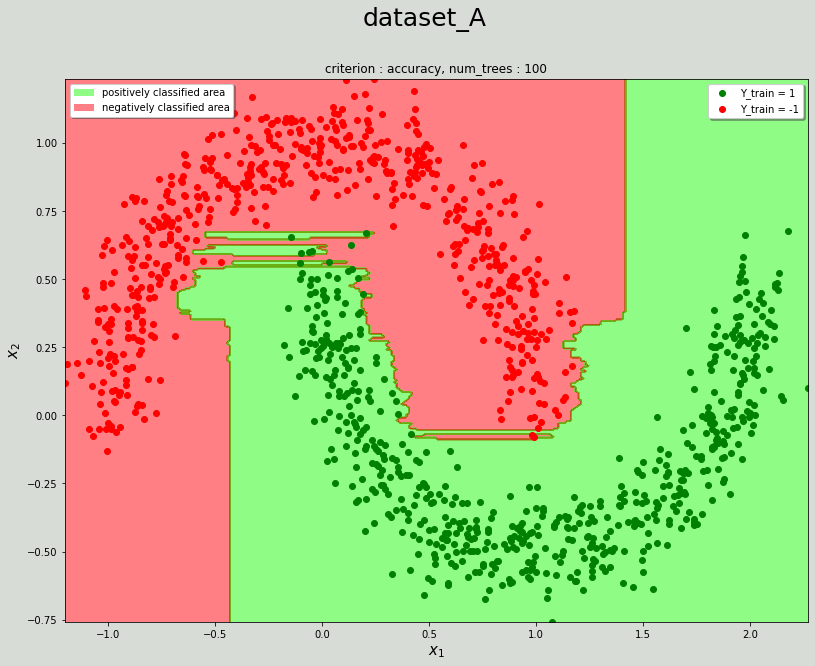

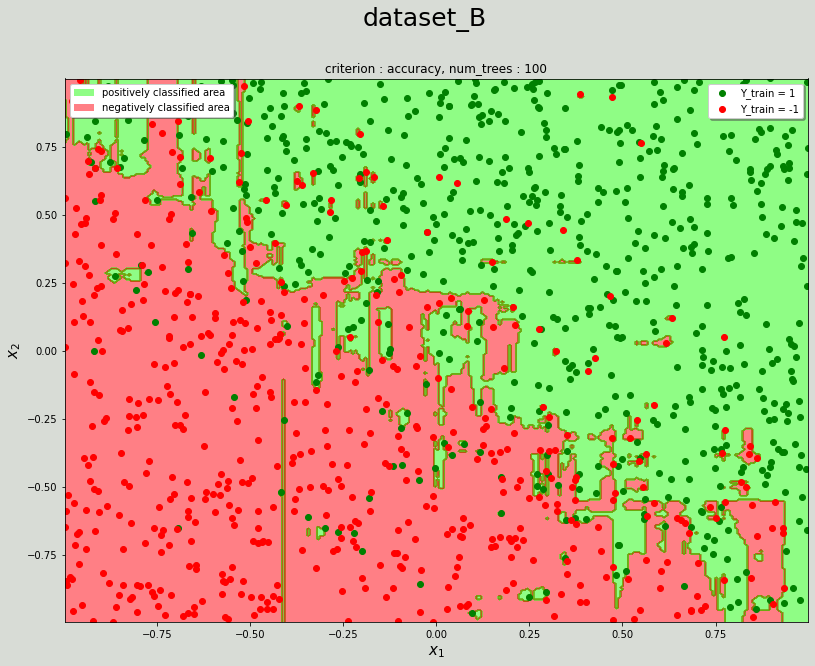

In [8]:
## Codewrite cell: Generate plots of learned Random Forest classifier on dataset_A and datasset_B.
# Plots should give both the learned classifier and the train data. 
# Plots required only for the accuracy criterion.
# Similar to  Bishop Figure 4.5 (with just two classes here.)
# Total number of plots = 2 
for i in range(2) :
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(13.33, 10, forward = True)
    fig.suptitle("dataset_" + chr((ord('A') + i)), fontsize = 25)
    fig.set_facecolor('xkcd:light grey')

    X_train_pos = {}
    X_train_neg = {}
    X_train_pos[i] = X_train[i][Y_train[i] == 1]
    X_train_neg[i] = X_train[i][Y_train[i] == -1]

    xx, yy = np.meshgrid(np.linspace(X_train[i][:, 0].min(), X_train[i][:, 0].max(), 300), np.linspace(X_train[i][:, 1].min(), X_train[i][:, 1].max(), 300))
    Za = eval_random_forest(best_validated_forest[('accuracy', i)], np.c_[xx.ravel(), yy.ravel()])
    Za = Za.reshape(xx.shape)
    CS = ax.contourf(xx, yy, Za, colors =  ('xkcd:bright red', 'xkcd:electric green'), alpha = 0.5)
    proxy = [plt.Rectangle((0,0),1,1,fc = pc.get_facecolor()[0]) for pc in CS.collections]
    legend = ax.legend(proxy[::-1], ["positively classified area", "negatively classified area"], loc = "upper left", fancybox = True, shadow = True)
    
    ax.scatter(X_train_pos[i][:, 0], X_train_pos[i][:, 1], color = 'g', label = 'Y_train = 1')
    ax.scatter(X_train_neg[i][:, 0], X_train_neg[i][:, 1], color = 'r', label = 'Y_train = -1')
        
    ax.set_title("criterion : " + "accuracy" + ", num_trees : " + str(best_parameters_forest[('accuracy', i)]))
    ax.set_xlabel("$x_1$", fontsize = 15)
    ax.set_ylabel("$x_2$", fontsize = 15)
    ax.legend(loc = 'upper right', fancybox = True, shadow = True)
    ax.add_artist(legend)

# 5 AdaBoost

Write code for learning using AdaBoost below. Use 3 different weak learners below. (You may reuse code written above)

1. 1 node decision tree 
2. Decision tree of fixed depth = 3 (Root, child, grand child)
3. Decision tree of fixed depth = 7 (Root, child, grand child, ..., great^4 grand child)

Run for 50 iterations. You may use the accuracy split criterion for all the three weak learners.

Write code for running in the next cell. (You may be asked to demonstrate your code during the viva using this cell.) 

In text cell after that report the following numbers you get by running appropriate code:

For all 4 data sets (A,B,C,D)  plot the train and test accuracy vs iterations. A total of 12 plots is expected. 4 datasets * 3 weak learners. Each plot should contain two curves, train and test error.  

For the synthetic classification datasets (datasets A and B) in 2-dimensions, also illustrate the learned classifier for each weak learner setting. A total of 6 contourf style plots are expected here. Do this in the last codeWrite cell for this question.

Summarise your observations in the last textwrite cell.

In [68]:
# Codewrite cell
# Write code to run here (no plotting)
def criterion_for_split_a(split, X_i, Y_train, W):
    Y_prediction = (X_i >= split)
    Y_prediction = Y_prediction.astype(int)
    Y_prediction[Y_prediction == 0] = -1
    accuracy = np.sum(W[Y_prediction == Y_train])/np.sum(W)
    return max(accuracy, 1 - accuracy)

def condition_a(X_train, Y_train, W):
    best = np.zeros(2)
    n = X_train.shape[0]
    d = X_train.shape[1]
    m_criterion = 0
    for i in range(d) :
        listofsplits = list_of_splits(X_train[:, i])
        for split in listofsplits:
            v_criterion = criterion_for_split_a(split, X_train[:, i], Y_train, W)
            if v_criterion > m_criterion :
                m_criterion = v_criterion
                best = np.array([split, i])
    return best

def train_decision_tree_h_depth(X, Y, num_nodes_stop, nodeid, tree, depth, W):
    if depth <= 0:
        pos = np.sum(W[Y == 1])/np.sum(W)
        if pos >= 0.5 :
            tree[nodeid] = np.array([None, None, 1]) # prediction is 1 
        else : 
            tree[nodeid] = np.array([None, None, -1]) # prediction is -1
        return tree
    else:
        n = X.shape[0]
        # check if the same point has been repeated
        pos = np.sum(W[Y == 1])/np.sum(W)
        if pos == 1 :
            tree[nodeid] = np.array([None, None, 1]) # prediction is 1 
            return tree
        elif pos == 0 : 
            tree[nodeid] = np.array([None, None, -1]) # prediction is -1
            return tree
        best = condition_a(X, Y, W)
        split, i = best
        best = np.append(best, 0) # for leaves, contains the predicted colour.
        tree[nodeid] = best
        if n <= num_nodes_stop :
            if pos >= 0.5 :
                tree[nodeid][2] = 1 # prediction is 1 
            else : 
                tree[nodeid][2] = -1 # prediction is 0
        else :
            nodeidl = 2 * nodeid
            nodeidr = 2 * nodeid + 1
            Xi = X[:, int(i)]
            tree = train_decision_tree_h_depth(X[Xi >= split], Y[Xi >= split], num_nodes_stop, nodeidr, tree, depth - 1, W[Xi >= split])
            tree = train_decision_tree_h_depth(X[Xi < split], Y[Xi < split], num_nodes_stop, nodeidl, tree, depth - 1, W[Xi < split])
        return tree

def train_decision_tree_depth(X, Y, depth, W, num_nodes_stop=1):
    """  Returns a decision tree trained on X and Y. 
    Stops splitting nodes when a node has hit a size of "num_nodes_stop" or lower.
    Split criterion can be either 'accuracy' or 'entropy'.
    Returns a tree (In whatever format that you find appropriate)
    """ 
    tree = {}
    tree = train_decision_tree_h_depth(X, Y, num_nodes_stop, 1, tree, depth, W)
    return tree

def eval_adaboost(forest, beta_array, X_test):
    hx = np.zeros(X_test.shape[0]) 
    for tree, beta in [(forest[i], beta_array[i]) for i in range(forest.shape[0])]:
        hx += eval_decision_tree(tree, X_test)*np.log(beta)
    hx = np.sign(hx)
    hx[hx == 0] = 1
    return hx

def adaboost(X, Y, depth, num_nodes_stop=1, epsilon=1e-50):
    n = X.shape[0]
    W = np.ones((n))
    forest = np.array([])
    beta_array = np.array([])
    gamma = None
    for t in range(50):
        tree = train_decision_tree_depth(X, Y, depth, W, num_nodes_stop)
        forest = np.append(forest, tree)
        pred = eval_decision_tree(tree, X)
        temp = np.sum(W[pred != Y])/np.sum(W)
        gamma = 0.5 - temp
        beta = (0.5 + gamma)/(0.5 - gamma + epsilon)
        beta_array = np.append(beta_array, beta)
        W = W * (beta**(pred!=Y).astype(int))
    return (forest, beta_array)

def plot_h(forest, beta_array, X, Y):
    error_array = np.array([]) 
    hx = np.zeros(X.shape[0]) 
    for i in range(forest.shape[0]):
        hx += eval_decision_tree(forest[i], X)*np.log(beta_array[i])
        pred = np.sign(hx)
        pred[pred == 0] = -1
        error_array = np.append(error_array, pred[pred != Y].shape[0]/pred.shape[0])
    return error_array


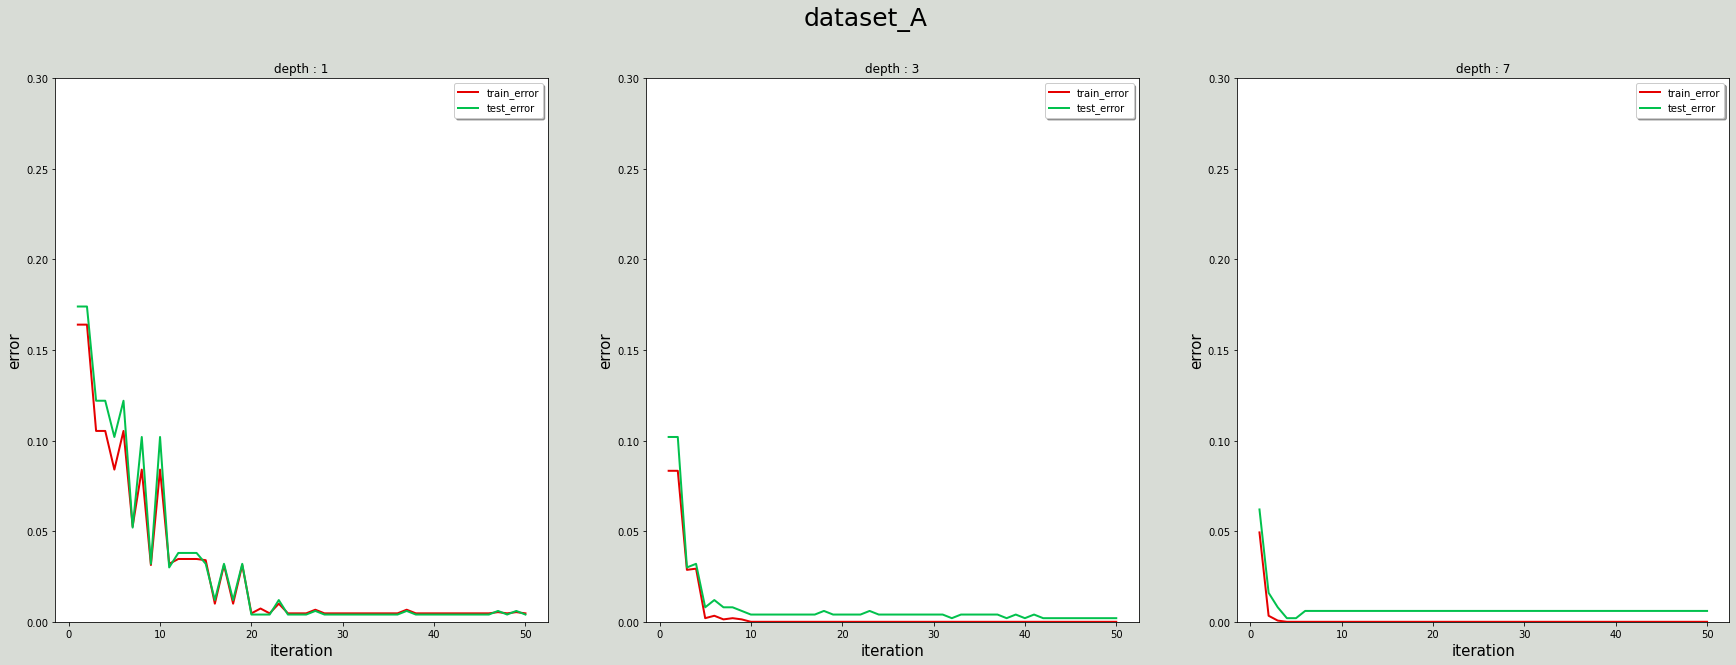

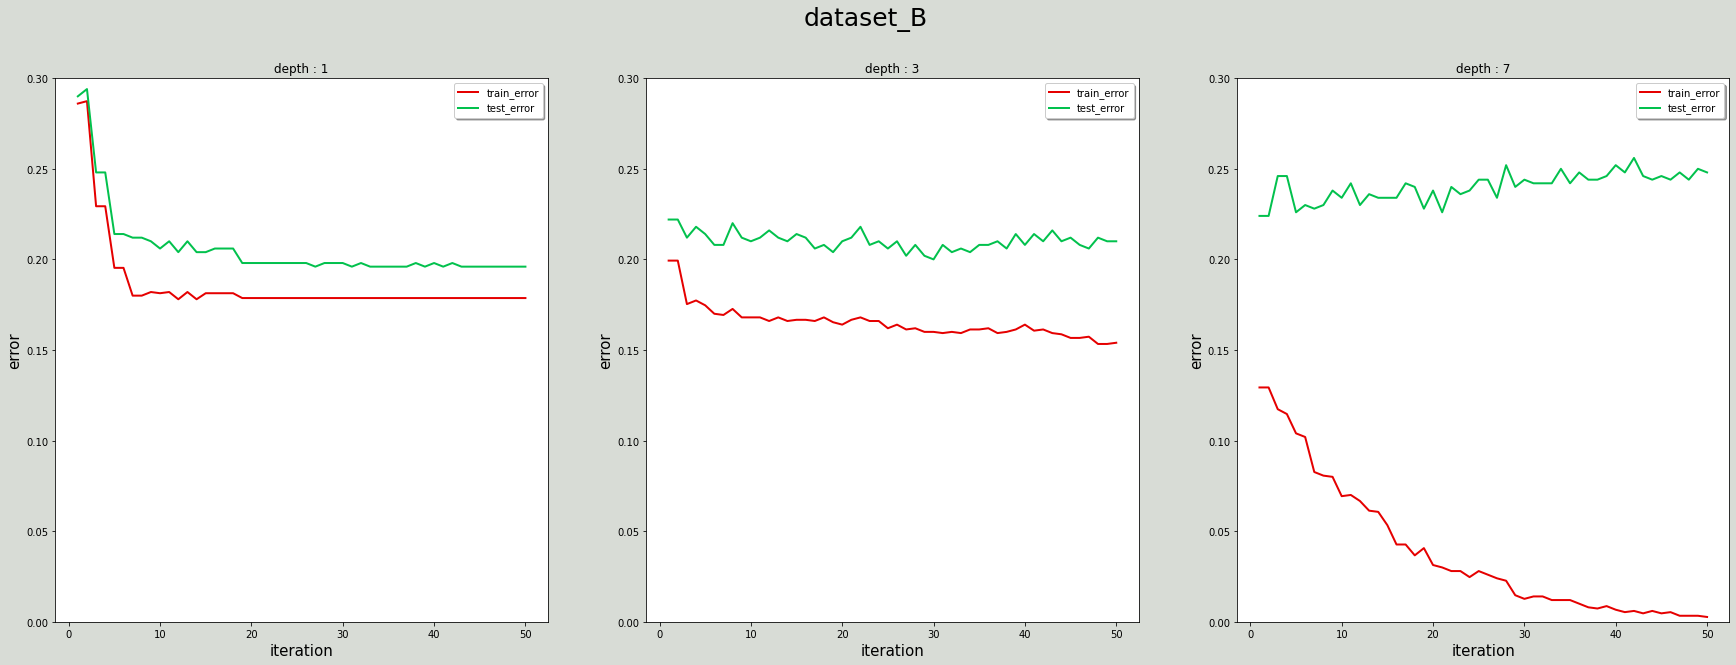

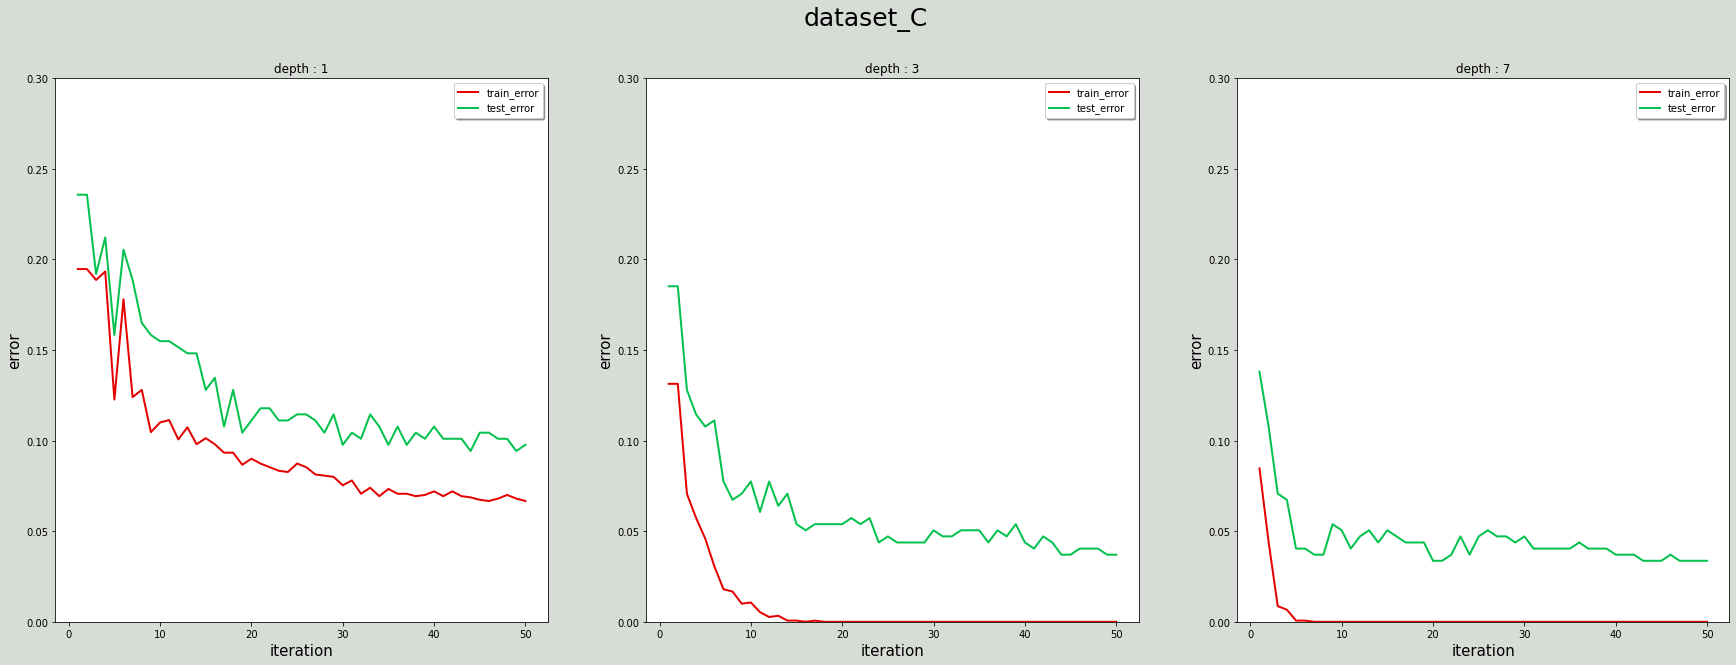

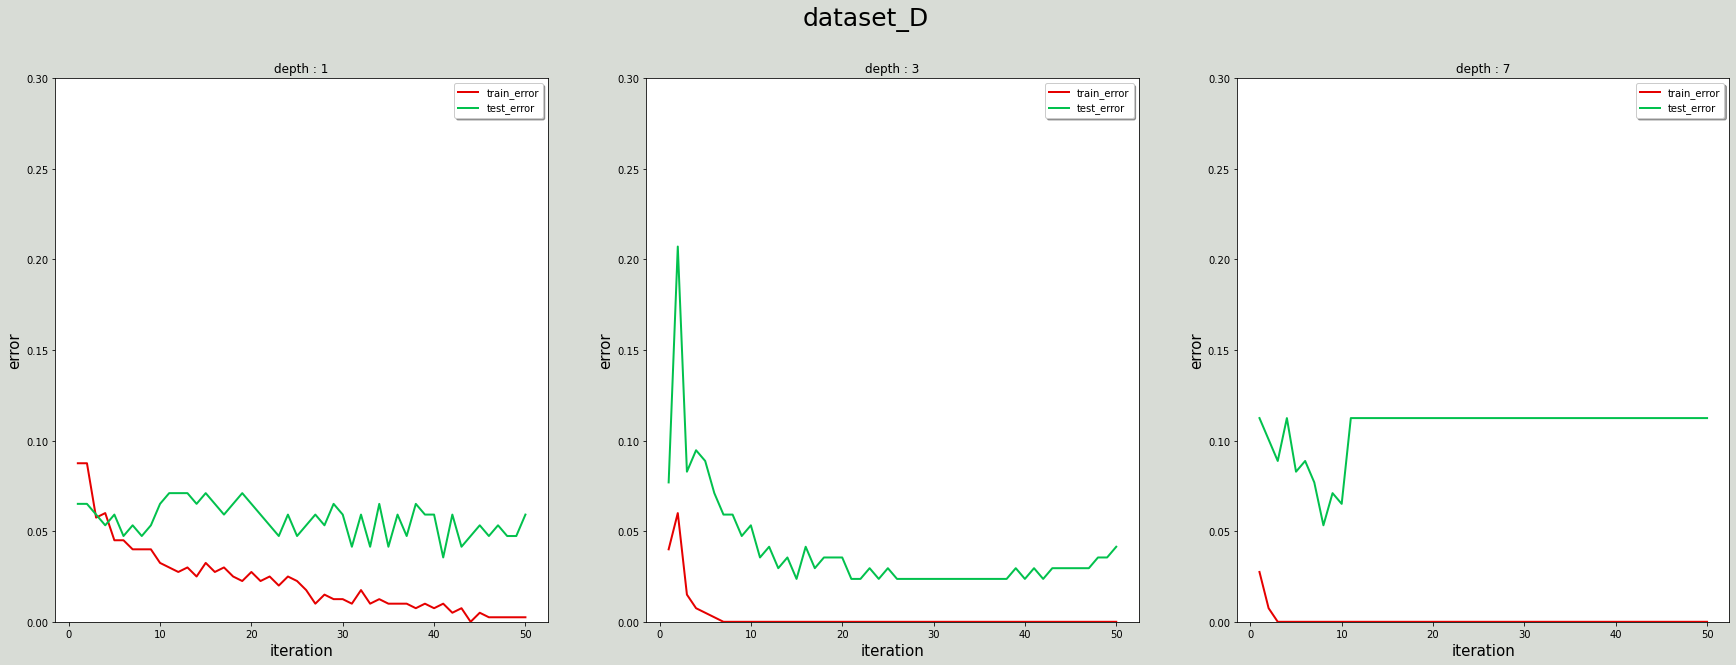

In [69]:
# Codewrite cell 
# Plots for iteration vs error here
dataset = {}
dataset[0] = np.load('../../Data/dataset_A.npz')
dataset[1] = np.load('../../Data/dataset_B.npz')
dataset[2] = np.load('../../Data/dataset_C.npz')
dataset[3] = np.load('../../Data/dataset_D.npz')


X_test = {}
Y_test = {}
X_train = {}
Y_train = {}

for i in range(4) :
    X_train[i] = dataset[i]['arr_0']
    Y_train[i] = dataset[i]['arr_1']
    X_test[i] = dataset[i]['arr_2']
    Y_test[i] = dataset[i]['arr_3']

for i in range(4) : 
    fig, ax = plt.subplots(1, 3)
    fig.set_size_inches(30, 10, forward = True)
    fig.suptitle("dataset_" + chr((ord('A') + i)), fontsize = 25)
    fig.set_facecolor('xkcd:light grey')

    forest = {}
    beta_array = {}
    train_error_array = {}
    test_error_array = {}
    gamma_array = {}

    for depth in [1, 3, 7] :
        forest[depth], beta_array[depth]= adaboost(X_train[i], Y_train[i], depth)
        train_error_array[depth]= plot_h(forest[depth], beta_array[depth], X_train[i], Y_train[i])
        test_error_array[depth] = plot_h(forest[depth], beta_array[depth], X_test[i], Y_test[i])

    iteration = np.arange(1, 51)
    temp_dict = {0:1, 1:3, 2:7}
    for j in range(3) :
        ax[j].plot(iteration, train_error_array[temp_dict[j]], 'xkcd:red', label = 'train_error', linewidth=2)
        ax[j].plot(iteration, test_error_array[temp_dict[j]], 'xkcd:shamrock green', label = 'test_error', linewidth=2)
        ax[j].set_title("depth : " + str(temp_dict[j]))
        ax[j].set_ylim(0, 0.3)
        ax[j].set_xlabel("iteration", fontsize = 15)
        ax[j].set_ylabel("error", fontsize = 15)
        ax[j].legend(loc = 'upper right', fancybox = True, shadow = True)
        

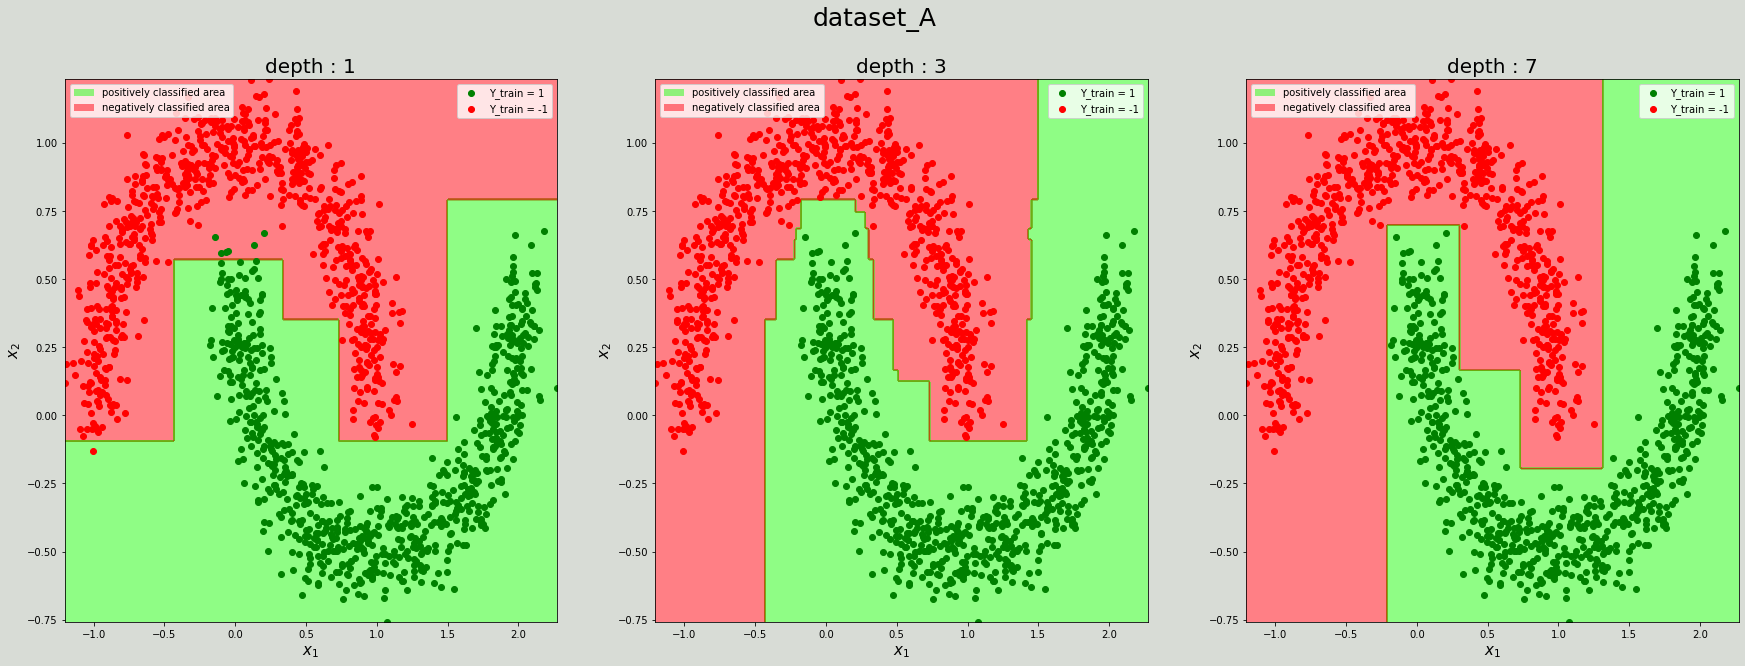

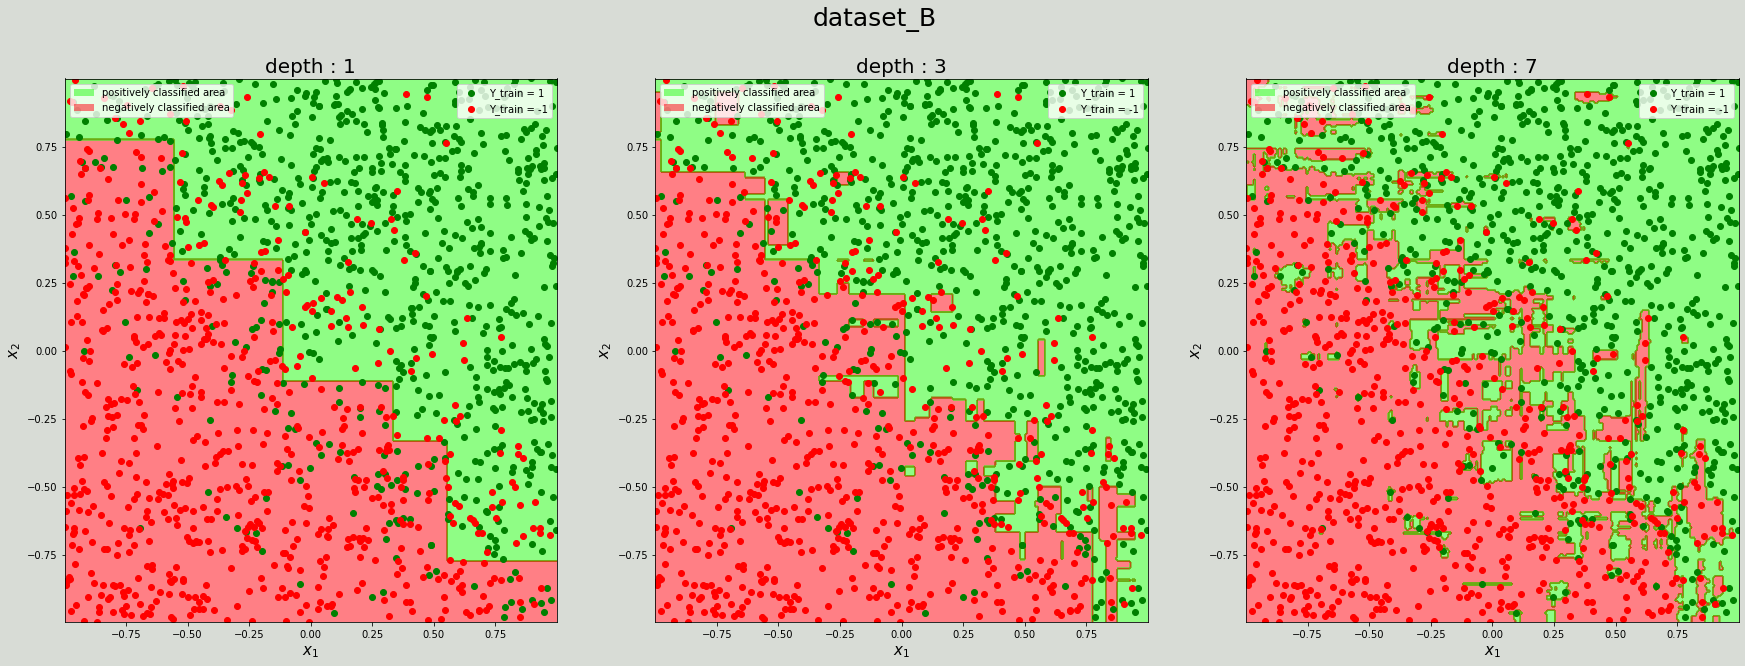

In [70]:
# Codewrite cell 
# Plots for illustrating the classifier here
for i in range(2) :
    fig, ax = plt.subplots(1, 3)
    fig.set_size_inches(30, 10, forward = True)
    fig.suptitle("dataset_" + chr((ord('A') + i)), fontsize = 25)
    fig.set_facecolor('xkcd:light grey')

    X_train_pos = {}
    X_train_neg = {}
    X_train_pos[i] = X_train[i][Y_train[i] == 1]
    X_train_neg[i] = X_train[i][Y_train[i] == -1]

    forest = {}
    beta_array = {}
    for depth in [1, 3, 7] :
        forest[depth], beta_array[depth] = adaboost(X_train[i], Y_train[i], depth)

    xx, yy = np.meshgrid(np.linspace(X_train[i][:, 0].min(), X_train[i][:, 0].max(), 300), np.linspace(X_train[i][:, 1].min(), X_train[i][:, 1].max(), 300))
    temp_dict = {0:1, 1:3, 2:7}
    legend = {}
    for j in range(3) :
        Z = eval_adaboost(forest[temp_dict[j]], beta_array[temp_dict[j]], np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        CS = ax[j].contourf(xx, yy, Z, colors = ('xkcd:bright red', 'xkcd:electric green'), alpha = 0.5)
        proxy = [plt.Rectangle((0,0),1,1,fc = pc.get_facecolor()[0]) for pc in CS.collections]
        legend[j] = ax[j].legend(proxy[::-1], ["positively classified area", "negatively classified area"], loc = "upper left")
    
    for j in range(3) :
        ax[j].scatter(X_train_pos[i][:, 0], X_train_pos[i][:, 1], color = 'g', label = 'Y_train = 1')
        ax[j].scatter(X_train_neg[i][:, 0], X_train_neg[i][:, 1], color = 'r', label = 'Y_train = -1')
        
    for j in range(3) :
        ax[j].set_title("depth : " + str(temp_dict[j]), fontsize = 20)
        ax[j].set_xlabel("$x_1$", fontsize = 15)
        ax[j].set_ylabel("$x_2$", fontsize = 15)
        ax[j].legend(loc = 'upper right')
        ax[j].add_artist(legend[j])

TextWrite cell: Give your observations and the list of hyperparameter choices and train zero-one error  and test zero-one error, for all 4 datasets (2 real world and 2 synthetic). 
#### Upper bound on the error

$\frac{M}{m} \leq \prod\limits_{t = 1}^{T} (1 - 4\gamma_{t}^2)$

where

$M$ is the number of mis-classifications made by our current classifier

$m$ is the number of training samples 

$\gamma_t$ is computed at every iteration as (accuracy of the weak learner - 0.5)

$T$ is the number of iterations
 
#### Observations

* We can see that adaboost is able to manage the weak classifiers to achieve a good training accuracy as seen in the above plots. It has managed to boost the weak classifiers to perform comparable to random forest in terms of training error.

* The equation shows that in the limit that the number of iterations $\rightarrow \infty$, the training error converges to 0.

* From the plots, we can observe that the training error stabilizes quicker (lesser iterations) with increase in depth of the decision tree. This can be explained with the above equation, with larger depth decision trees, we have more accurate weak learners and hence we have larger $\gamma_t$'s and hence we need lesser $T$ to reduce $\prod\limits_{t = 1}^{T}(1 - 4\gamma_t^2)$ to a reasonably small value.

* As the depth increases we can see in some cases (like depth 7 for dataset B) that the test error tends to increase though training error is very small after 50 iterations. This tells us that it tends to overfit if we use "stronger" weak learners. This can be seen in the contour plots as well.